In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from wordcloud import WordCloud, STOPWORDS
from nltk import sent_tokenize,word_tokenize 
import gensim.summarization

#!pip install langdetect
#!pip install deep-translator
from langdetect import detect
from deep_translator import GoogleTranslator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

<h1> Staging the Data </h1>

<h2> Read the data files and concatenate </h2>

In [2]:
df1 = pd.read_csv('7282_1.csv')
df2 = pd.read_csv('Datafiniti_Hotel_Reviews_Jun19.csv')
df3 = pd.read_csv('Datafiniti_Hotel_Reviews.csv')

In [3]:
print('Number of observations in df1: ', len(df1))
print('Number of observations in df2: ', len(df2))
print('Number of observations in df3: ', len(df3))
print('Total number of observations in the raw dataset should then be: ', len(df1)+len(df2)+len(df3))

Number of observations in df1:  35912
Number of observations in df2:  10000
Number of observations in df3:  10000
Total number of observations in the raw dataset should then be:  55912


In [4]:
df = pd.concat([df1, df2, df3])

<h3>Examining the data in the Dataframe</h3>

<p>We can print out the info of the dataframe,to check the resulting dataframe</p>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55912 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   address               55912 non-null  object 
 1   categories            55912 non-null  object 
 2   city                  55912 non-null  object 
 3   country               55912 non-null  object 
 4   latitude              55826 non-null  float64
 5   longitude             55826 non-null  float64
 6   name                  55912 non-null  object 
 7   postalCode            55857 non-null  object 
 8   province              55912 non-null  object 
 9   reviews.date          55653 non-null  object 
 10  reviews.dateAdded     35912 non-null  object 
 11  reviews.doRecommend   0 non-null      float64
 12  reviews.id            0 non-null      float64
 13  reviews.rating        55050 non-null  float64
 14  reviews.text          55889 non-null  object 
 15  reviews.title       

<p>Several data columns are such that only 20,000 observations are non-null values, which is the total size of df2 and df3 together. This is indicative that these columns are not present in df1. More, many of these columns are extraneous as the information is already captured in the columns that they have in common with df1</p>

<h3>Merging the dataset with inner join</h3>

<p>Concatenating each dataframe such that only common columns are present in the resulting dataset.</p>

In [72]:
df = pd.concat([df1, df2, df3],join='inner',ignore_index=True)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55912 entries, 0 to 55911
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   address               55912 non-null  object 
 1   categories            55912 non-null  object 
 2   city                  55912 non-null  object 
 3   country               55912 non-null  object 
 4   latitude              55826 non-null  float64
 5   longitude             55826 non-null  float64
 6   name                  55912 non-null  object 
 7   postalCode            55857 non-null  object 
 8   province              55912 non-null  object 
 9   reviews.date          55653 non-null  object 
 10  reviews.rating        55050 non-null  float64
 11  reviews.text          55889 non-null  object 
 12  reviews.title         54288 non-null  object 
 13  reviews.userCity      30427 non-null  object 
 14  reviews.username      55869 non-null  object 
 15  reviews.userProvinc

<p>We can print out some sample rows to check to examine the data</p>

In [74]:
df.rename(columns = {
    col : f"{col} ({dtype})"
    for col, dtype in df.dtypes.to_dict().items()
}).sample(5, random_state = 0)

address (object)  \
12857  1071 E El Camino Real   
31351        35 Via Pico Plz   
11350    741 E Washington St   
38032    100 Colleton Ave SW   
12359           7070 Poe Ave   

                                     categories (object) city (object)  \
12857                                             Hotels     Sunnyvale   
31351                                             Hotels  San Clemente   
11350  Cocktail Lounges,Restaurants,Hotels,Casinos,Lo...  Charles Town   
38032                           Hotels,Hotel,Restaurants         Aiken   
12359                                             Hotels        Dayton   

      country (object)  latitude (float64)  longitude (float64)  \
12857               US           37.352307          -122.003242   
31351               US           33.437538          -117.621732   
11350               US           39.293040           -77.850866   
38032               US           33.557110           -81.721620   
12359               US           39.849845           -84.189419   

                          name (object) postalCode (object) province (object)  \
12857                Cherry Orchard Inn               94087                CA   
31351  Holiday Inn Express San Clemente               92672                CA   
11350                        Turf Motel               25414                WV   
38032                       The Willcox               29801                SC   
12359      Hawthorn Suites Dayton North               45414                OH   

      reviews.date (object)  reviews.rating (float64)  \
12857  2015-08-23T00:00:00Z                       3.0   
31351  2016-03-25T00:00:00Z                       4.0   
11350  2016-03-12T00:00:00Z                       4.0   
38032  2016-04-30T00:00:00Z                       1.0   
12359  2016-06-15T00:00:00Z                       4.0   

                                   reviews.text (object)  \
12857  Arrived in our room to find hair in the bathtu...   
31351         Good convenient location. Very nice hotel.   
11350  My husband and I have stayed at the Turf sever...   
38032  I made a guaranteed reservation in October for...   
12359  It was very clean (fresh)and quiet, staff was ...   

                            reviews.title (object) reviews.userCity (object)  \
12857  OK stay for what was needed good be better.                       NaN   
31351                       This is an okay hotel.             West Columbia   
11350                                   Turf Motel                  Virginia   
38032     Unilaterally cancelled my reservation...                  Lewiston   
12359                                          WOW                       NaN   

      reviews.username (object) reviews.userProvince (object)  
12857                      TINA                           NaN  
31351                A Traveler                            SC  
11350            BettyKVirginia                            VA  
38032            barolobrunello                            NY  
12359                  michelle                           NaN

<h2> Initial Data Cleaning </h2>

Check out the reviews columns in more detail

In [75]:
df.loc[:, df.columns.str.startswith("review")]

reviews.date  reviews.rating  \
0          2013-09-22T00:00:00Z             4.0   
1          2015-04-03T00:00:00Z             5.0   
2          2014-05-13T00:00:00Z             5.0   
3          2013-10-27T00:00:00Z             5.0   
4          2015-03-05T00:00:00Z             5.0   
...                         ...             ...   
55907      2016-03-13T00:00:00Z             3.0   
55908      2015-12-11T00:00:00Z             4.0   
55909  2017-11-17T00:00:00.000Z             4.0   
55910      2016-06-09T00:00:00Z             1.0   
55911  2013-09-03T00:00:00.000Z             1.0   

                                            reviews.text  \
0      Pleasant 10 min walk along the sea front to th...   
1      Really lovely hotel. Stayed on the very top fl...   
2      Ett mycket bra hotell. Det som drog ner betyge...   
3      We stayed here for four nights in October. The...   
4      We stayed here for four nights in October. The...   
...                                                  ...   
55907  It is hard for me to review an oceanfront hote...   
55908  I live close by, and needed to stay somewhere ...   
55909  Rolled in 11:30 laid out heads down woke up to...   
55910  Absolutely terrible..I was told I was being gi...   
55911  Filthy, outdated, noisy neighbours, but this w...   

                            reviews.title     reviews.userCity  \
0      Good location away from the crouds                  NaN   
1          Great hotel with Jacuzzi bath!                  NaN   
2                             Lugnt l��ge                  NaN   
3              Good location on the Lido.                  NaN   
4                  ������ ���������������                  NaN   
...                                   ...                  ...   
55907          Picture Window Ocean View!             Wildwood   
55908        Clean, comfortable and quiet        East Sandwich   
55909                     Passing through              Montana   
55910                            Terrible             woodbury   
55911                               Polde  Sempeter pri Gorici   

      reviews.username reviews.userProvince  
0          Russ (kent)                  NaN  
1           A Traveler                  NaN  
2                 Maud                  NaN  
3                Julie                  NaN  
4             sungchul                  NaN  
...                ...                  ...  
55907         LASH0211                   GA  
55908         Gennaker                   MA  
55909         Amber406         UnitedStates  
55910      donWoodbury                  NaN  
55911       janezr2013             Slovenia  

[55912 rows x 7 columns]

<p> Drop the rows where review ratings or review texts are not available</p>

In [76]:
df.dropna(subset = ['reviews.rating', 'reviews.text'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55027 entries, 0 to 55911
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   address               55027 non-null  object 
 1   categories            55027 non-null  object 
 2   city                  55027 non-null  object 
 3   country               55027 non-null  object 
 4   latitude              54951 non-null  float64
 5   longitude             54951 non-null  float64
 6   name                  55027 non-null  object 
 7   postalCode            54972 non-null  object 
 8   province              55027 non-null  object 
 9   reviews.date          54770 non-null  object 
 10  reviews.rating        55027 non-null  float64
 11  reviews.text          55027 non-null  object 
 12  reviews.title         54152 non-null  object 
 13  reviews.userCity      30299 non-null  object 
 14  reviews.username      54984 non-null  object 
 15  reviews.userProvinc

Rename the reviews columns

In [77]:
old_names = ['reviews.date', 'reviews.rating', 'reviews.title', 'reviews.text', 'reviews.userCity', 
             'reviews.username', 'reviews.userProvince'] 
new_names = ['date', 'rating', 'title', 'text', 'userCity', 'username', 'userProvince']
df.rename(columns = dict(zip(old_names, new_names)), inplace = True)

Replace the empty titles with an empty string instead of NaN

In [78]:
df['title'].fillna('', inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55027 entries, 0 to 55911
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   address       55027 non-null  object 
 1   categories    55027 non-null  object 
 2   city          55027 non-null  object 
 3   country       55027 non-null  object 
 4   latitude      54951 non-null  float64
 5   longitude     54951 non-null  float64
 6   name          55027 non-null  object 
 7   postalCode    54972 non-null  object 
 8   province      55027 non-null  object 
 9   date          54770 non-null  object 
 10  rating        55027 non-null  float64
 11  text          55027 non-null  object 
 12  title         55027 non-null  object 
 13  userCity      30299 non-null  object 
 14  username      54984 non-null  object 
 15  userProvince  30109 non-null  object 
dtypes: float64(3), object(13)
memory usage: 7.1+ MB


## Remove Placeholders

Before we start analysis lets take a closer look in to the reviews

In [79]:
df[df['title'] == ''][['title','text']]

title                                               text
57           to share your opinion of this businesswith YP ...
58           to share your opinion of this businesswith YP ...
59           to share your opinion of this businesswith YP ...
97           to share your opinion of this businesswith YP ...
98                  xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
...     ...                                                ...
35743        to share your opinion of this businesswith YP ...
35910        to share your opinion of this businesswith YP ...
35911               xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
40680        Staffs and service were excellent. I will defi...
46512        Bad: Fit and finish construction of rooms coul...

[875 rows x 2 columns]

In [80]:
df.loc[57]['text']

'to share your opinion of this businesswith YP visitors across the United Statesand in your neighborhood'

In [81]:
df_noreviews = df[df['text']=='to share your opinion of this businesswith YP visitors across the United Statesand in your neighborhood']['text']
len(df_noreviews)

199

Removing the rows with review place holders

In [82]:
df = df[df['text']!='to share your opinion of this businesswith YP visitors across the United Statesand in your neighborhood']
df[df['title'] == ''][['title','text']]

title                                               text
98                  xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
184          Came to Binghamton to visit with a relative. F...
185          Great Experience. Nice Staff clean rooms good ...
247                 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
885          The motel was clean and comfortable bed and a ...
...     ...                                                ...
35521        The bath tub spa in the room is great! We had ...
35592        It was pleasant and near to my family who we w...
35911               xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
40680        Staffs and service were excellent. I will defi...
46512        Bad: Fit and finish construction of rooms coul...

[730 rows x 2 columns]

In [83]:
df.loc[98]['text']

'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'

In [84]:
df_noreviews = df[df['text']=='xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx']['text']
print('There is a total of', len(df_noreviews), 'reviews with the place holder')

There is a total of 105 reviews with the place holder


In [85]:
df = df[df['text']!='xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx']
df[df['title'] == ''][['title','text']]

title                                               text
184          Came to Binghamton to visit with a relative. F...
185          Great Experience. Nice Staff clean rooms good ...
885          The motel was clean and comfortable bed and a ...
925          The Hotel was perfect and the food was excelle...
1261         VERY FRIENDLY AND GREAT PRICE. I HAVE STAYED A...
...     ...                                                ...
35520        Unique and beautiful place. We admire the owne...
35521        The bath tub spa in the room is great! We had ...
35592        It was pleasant and near to my family who we w...
40680        Staffs and service were excellent. I will defi...
46512        Bad: Fit and finish construction of rooms coul...

[650 rows x 2 columns]

## Convert non-ASCII, non-English reviews into English reviews

In [15]:
df['review'] = df['title'] + ' ' + df['text']

In [16]:
df = df[df.review.apply(lambda x: len(str(x)) > 10)]

def review_transform(t):
    temp = t.encode('ascii', 'ignore').decode('utf-8').strip() #transform unrecognized text      
    if len(temp) > 12 and any(c.isalpha() for c in temp): #min length of review is 10, must contain character
        if detect(temp) != 'en':
            temp = GoogleTranslator(source='auto', target='en').translate(temp)
            
    return temp
    
df['review'] = df['review'].apply(lambda t: review_transform(t))
df = df[df['review'].apply(lambda x: len(x) > 10)]

In [17]:
# Testing translator
to_translate = '我想吃饭'
translated = GoogleTranslator(source='auto', target='en').translate(to_translate)
translated

'I want to eat'

<h2> Ratings distribution </h2>

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set()

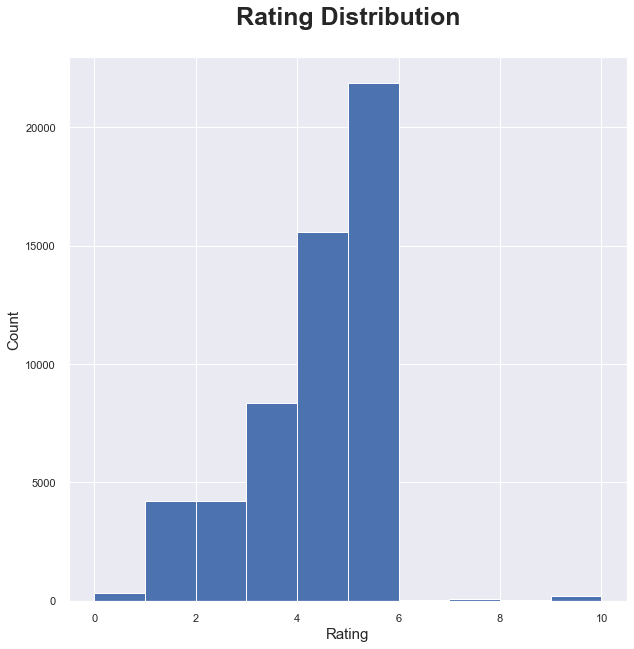

In [19]:
plt.figure(figsize=(10,10))

plt.hist(df['rating'], 10, density = False, 
         histtype ='bar')

plt.xlabel('Rating', fontdict = {'fontsize' : 15})
plt.ylabel('Count', fontdict = {'fontsize' : 15})
 
plt.title('Rating Distribution\n',
          fontweight ="bold", fontdict = {'fontsize' : 25})
  
plt.show()

In [20]:
df['rating'].unique()

array([ 4.  ,  5.  ,  3.  ,  1.  ,  2.  ,  0.  ,  4.1 ,  4.9 ,  4.8 ,
        3.4 ,  2.4 ,  3.1 ,  3.2 ,  3.3 ,  9.6 , 10.  ,  8.3 ,  8.8 ,
        9.2 ,  7.5 ,  7.9 ,  7.1 ,  3.8 ,  5.8 ,  6.7 ,  6.3 ,  4.2 ,
        4.5 ,  3.9 ,  1.3 ,  4.3 ,  4.7 ,  2.8 ,  4.4 ,  1.5 ,  4.6 ,
        3.7 ,  5.4 ,  2.5 ,  6.  ,  2.9 ,  7.  ,  9.5 ,  3.55,  4.15,
        3.95,  3.35,  3.75,  2.1 ,  1.65,  3.15,  2.7 ,  1.45,  2.75,
        2.3 ,  3.5 ,  4.25,  1.25,  1.9 ,  3.45,  3.25,  4.75])

As we can see, not all ratings are an integers, and ratings range from 0 to 10, even though the majority fall within the range from 1-5

In [21]:
df['rating'].describe()

count    54940.000000
mean         3.879205
std          1.335277
min          0.000000
25%          3.000000
50%          4.000000
75%          5.000000
max         10.000000
Name: rating, dtype: float64

In [22]:
print("Number of ratings greater than 5:", df[df['rating'] > 5].shape[0])
print("Percent of ratings greater than 5:{0:1.2f}%".format( (df[df['rating'] > 5].shape[0] / df.shape[0])*100))

Number of ratings greater than 5: 357
Percent of ratings greater than 5:0.65%


There's only 0.65% of ratings greater than 5, and since the scales of these reviews are unclear (e.g., a 10-point review can be 10/10 or 10/100), we exclude them from subsequent analyses.

In [23]:
df['rating'].describe()

count    54940.000000
mean         3.879205
std          1.335277
min          0.000000
25%          3.000000
50%          4.000000
75%          5.000000
max         10.000000
Name: rating, dtype: float64

We also note that the minimum rating in the dataset is 0. The histogram plotted above indicates that the number of reviews with a rating of 0 is small relative to all other ratings. To assure that this the case, we compute the following:

In [24]:
print("Number of ratings equal to 0:", df[df['rating'] == 0].shape[0])
print("Percent of ratings equal to 0:{0:1.2f}%".format( (df[df['rating'] ==0].shape[0] / df.shape[0])*100))

Number of ratings equal to 0: 336
Percent of ratings equal to 0:0.61%


We see that only 0.61% of the dataset correspond to reviews with a rating of 0. While we have not formally tested for outliers in this dataset, observations with a rating greater than 5 or equal to 0 could be considered outliers due to their rare occurrence in the dataset. 
<p>However, we will not immediately remove these observations. We will first determine whether the hotels that use a 10-point rating scale and hotels that include 0 as a possible rating have other ratings that are between 1 and 5. If so, simply removing only observations could impact model performance. 

<h4>Analyzing the outliers</h4>

In [25]:
ten_scale_outliers = set() 
zero_rating_outliers = set()

for i in df.index:
    if df.rating[i] > 5:
        ten_scale_outliers.add(df.name[i])
    if df.rating[i] == 0:
        zero_rating_outliers.add(df.name[i])

print('Number of hotels with a 10 rating reviews:', len(ten_scale_outliers))
print('Number of hotels with a 0 rating reviews:',  len(zero_rating_outliers))

Number of hotels with a 10 rating reviews: 5
Number of hotels with a 0 rating reviews: 253


In [26]:
count10 = 0
count0 = 0

for i, hotel in enumerate(df.name):
    if hotel in ten_scale_outliers:
        count10 += 1
    if hotel in zero_rating_outliers:
        count0 += 1
        
print('Proportion of reviews corresponding to hotels using a 10-scale rating system = {0:1.2f}%'.format((count10/df.shape[0])*100))
print('Proportion of reviews corresponding to hotels that include a 0 in their rating scale = {0:1.2f}% '.format((count0/df.shape[0])*100))

Proportion of reviews corresponding to hotels using a 10-scale rating system = 1.41%
Proportion of reviews corresponding to hotels that include a 0 in their rating scale = 9.60% 


Therefore, hotels using a 10-point rating scale and hotels that include 0 as a rating, have other reviews with ratings that are less than 5 and greater than 0. We have four options:
<li> Ignore the issue and move on <span style="color:red"> <i> (Wrong Choice!)</i></span>
<li> Exclude all observations with ratings above 5 and reviews with ratings equal to 0. <span style="color:orange"> <i> (This would impact model performance, so this isn't an ideal approach)</i></span>
<li> Exclude all hotels in the dataset that use a 10-point rating scale and hotels that include 0 as a possible rating.<span style="color:orange"> <i> (Not necessarily a bad approach, but may not be a great one. We might be able to do better.)</i></span>
<li> Rescale reviews associated with hotels using a 10-point rating scale and hotels that include 0 as a possible rating to a 1-5 rating scale. <span style="color:green"> <i> (Our choice)</i></span>

<h4>Rescaling ratings</h4>

Instead of excluding reviews with ratings greater than 5 and reviews with ratings equal to 0, we will re-scale all reviews associated with these hotels to a 1-5 rating scale. Otherwise, simply removing reviews greater than 5 will likely impact the final model. Indeed, there will still be reviews in the dataset associated with these hotels, and reviews for such hotels with a rating of 4 or 5 likely won't be very positive as a 4 or 5 on a 10-point rating scale doesn't typically correlate with a satisfied guest. On the other hand, if were to exclude all hotels in the dataset that use a 10-point scale and hotels that include 0 as a possible rating, it would simply truncate a dataset that is already small enough. Therefore, in order to preserve as much data/information as possible, we will re-scale these reviews (see following code blocks).

In [27]:
for i in df.index:
    if df.name[i] in ten_scale_outliers:
        df.rating[i] = df.rating[i]/2
    if df.rating[i] < 1:
        df.rating[i] = 1

ten_scale_outliers = set()   

Redefining as an empty set in case this block of code is run again, which would otherwise decrease all ratings of hotels in ten_scale_outliers by a factor of 2 again. This would  effectively divide the original rating by 4, since the hotel values would still be in the set. To avoid this, we simply redefine it as an empty set since we will not need it beyond this point.

In [28]:
df['rating'].describe()

count    54940.000000
mean         3.841000
std          1.263678
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

Now, all ratings are between 1 and 5 (inclusive).

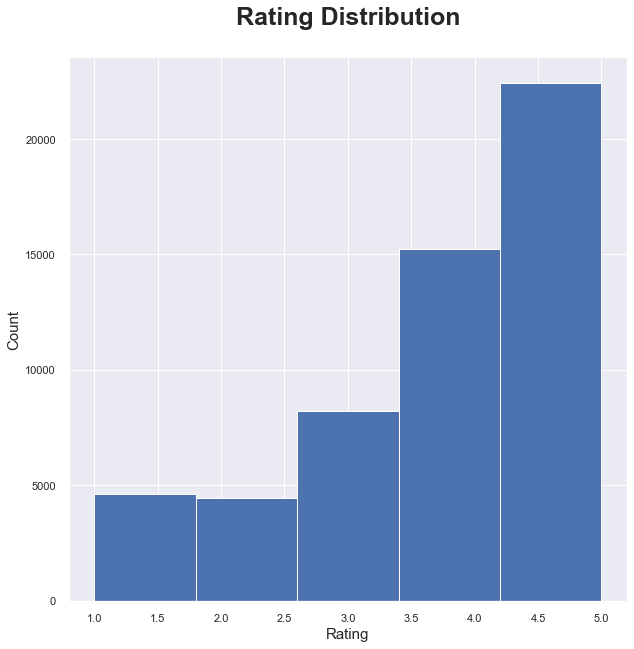

In [29]:
plt.figure(figsize=(10,10))

plt.hist(df['rating'], 5, density = False, 
         histtype ='bar')

plt.xlabel('Rating', fontdict = {'fontsize' : 15})
plt.ylabel('Count', fontdict = {'fontsize' : 15})
 
plt.title('Rating Distribution\n',
          fontweight ="bold", fontdict = {'fontsize' : 25})
  
plt.show()

<h2> Data Filtering, Exclusions, and Segmentation Analysis </h2>

In [45]:
df_int = df.copy()
df_int.rating = df_int.rating.astype(int)

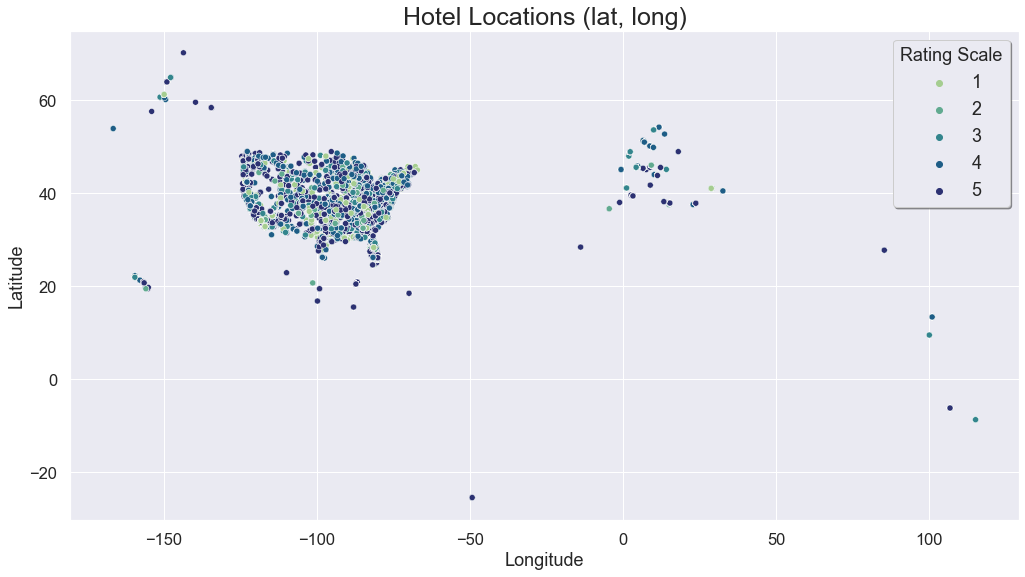

In [46]:
%matplotlib inline
#import matplotlib.pyplot as plt
#import seaborn as sns
plt.style.use('seaborn')

sns.set(rc={"figure.figsize":(17, 9)}, font_scale=1.5) 
p=sns.scatterplot(data=df_int, x='longitude', y='latitude', hue='rating',
                markers='.', legend='full',palette='crest')

p.set_title('Hotel Locations (lat, long)', fontsize = 25)
p.set_xlabel("Longitude", fontsize = 18)
p.set_ylabel("Latitude", fontsize = 18)
plt.legend(fontsize='medium', title='Rating Scale', shadow='True', frameon='True')

In [47]:
# import json
# import geojsonio
# import folium

# # convert Full Address, Latitude and Longitude dataframe columns to list
# df_coord = df[['name', 'latitude', 'longitude']]

# df_coord.drop_duplicates(inplace = True)

# df_coord.dropna(subset = ['latitude', 'longitude'], inplace = True)

# long_list = list(df_coord["longitude"])
# lat_list = list(df_coord["latitude"])
# name_list = list(df_coord['name'])


# # create folium map object
# geocoded_map = folium.Map(location=[40, -95], zoom_start=4) # location=[Lat, Long]

# for long, lat in zip(long_list, lat_list):
#     #geocoded_map.add_child(folium.Marker(location=[lat, long])
#     #geocoded_map.add_child(folium.CircleMarker(location=[lat, long], radius=5, color='green', fill_color='green', fill_opacity=.2))
    
#     #folium.Marker([lat, long], popup = name).add_to(geocoded_map)
#     folium.Marker([lat, long]).add_to(geocoded_map)
             
# geocoded_map

Most of the reviews appear to be for hotels in the U.S.. 
<p>We also see that the ratings appear to be evenly distributed with respect to location.

In [48]:
df.country.unique()

array(['US'], dtype=object)

Despite the plot showing that there are reviews outside of the U.S., the country column indicates that all reviews are in the U.S.. It's not clear if this will have any impact on model performance.

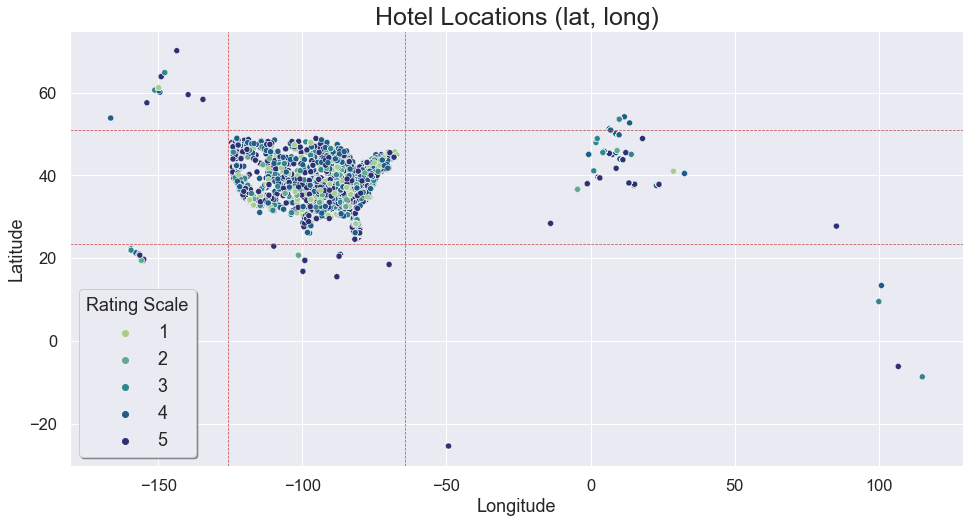

In [49]:
%matplotlib inline
plt.style.use('seaborn')

sns.set(rc={"figure.figsize":(16, 8)}, font_scale=1.5) 
p=sns.scatterplot(data=df_int, x='longitude', y='latitude', hue='rating',
                markers='.', legend='full',palette='crest')

p.axhline(y = 51.0, color = 'r', linestyle = '--', linewidth=0.75)
p.axhline(y = 23.5, color = 'r', linestyle = '--', linewidth=0.75)
p.axvline(x = -64.5, color = 'r', linestyle = '--', linewidth=0.75)
p.axvline(x = -126.0, color = 'r', linestyle = '--', linewidth=0.75)
p.set_title('Hotel Locations (lat, long)', fontsize = 25)
p.set_xlabel("Longitude", fontsize = 18)
p.set_ylabel("Latitude", fontsize = 18)
plt.legend(fontsize='medium', title='Rating Scale', shadow='True', frameon='True')

In [50]:
df_US = df[((df['latitude']<=51.0) & (df['latitude']>=23.5)) & 
         ((df['longitude']<=-64.5) & (df['longitude']>=-126.0))]

In [51]:
print('There are',len(df) - len(df_US),'reviews outside the U.S.')
print('This is {0:1.2f}%'.format(((len(df) - len(df_US))/ len(df))*100), 'of all reviews')

There are 3817 reviews outside the U.S.
This is 6.95% of all reviews


Filtering out all locations outside of the U.S.

In [52]:
df = df[((df['latitude']<=51.0) & (df['latitude']>=23.5)) & 
         ((df['longitude']<=-64.5) & (df['longitude']>=-126.0))]

In [53]:
df_new = df.copy()
df_new.rating = df_new.rating.astype(int)

Plot another scatter plot, but on the truncated dataset (constrained to only those hotel reviews within the U.S.).

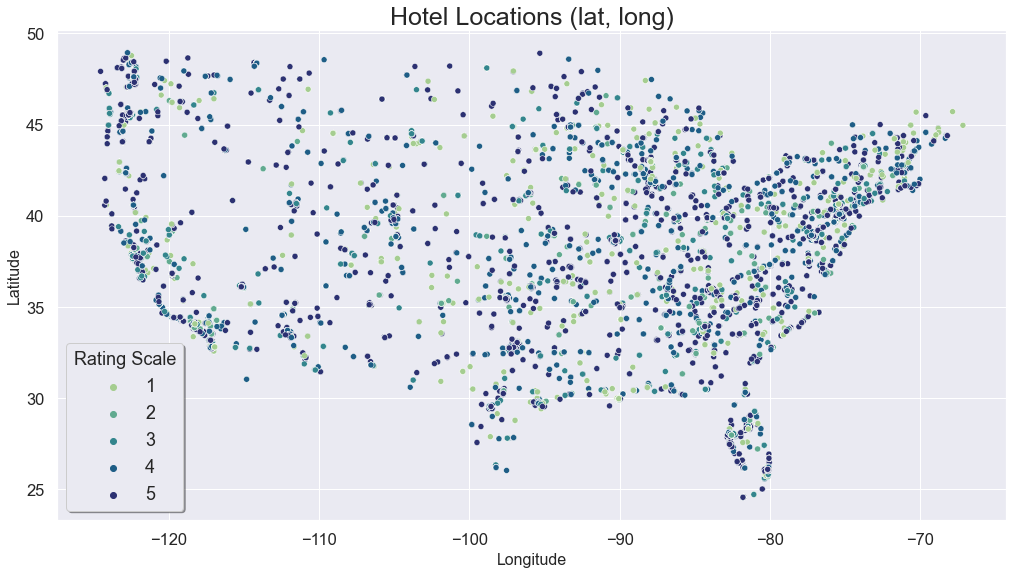

In [54]:
sns.set(rc={"figure.figsize":(17, 9)}, font_scale=1.5) 
p=sns.scatterplot(data=df_new, x='longitude', y='latitude', hue='rating',
                markers='.', legend='full',palette='crest')

p.set_title('Hotel Locations (lat, long)', fontsize = 25)
p.set_xlabel("Longitude", fontsize = 16)
p.set_ylabel("Latitude", fontsize = 16)
plt.legend(fontsize='medium', title='Rating Scale', shadow='True', frameon='True')

# <h1> Exploratory Data Analysis </h1>

In [55]:
#!pip install geocoder
import geocoder

def get_state(df):
    g = geocoder.osm([df.latitude, df.longitude], method = 'reverse').json
    if g:
        try:
            state = g.get('state')
            #zip_code = g.get('postcode')
        except:
            pass
        return state
    else:
        return 'no state'

def get_zip(df):
    g = geocoder.osm([df.latitude, df.longitude], method = 'reverse').json
    if g:
        try:
            #state = g.get('state')
            zip_code = g.get('postal')
        except:
            pass
        return zip_code
    else:
        return 'no zip_code'

In [57]:
df_coord = df[['name', 'latitude', 'longitude']]

df_coord.drop_duplicates(inplace = True)

df_coord.dropna(subset = ['latitude', 'longitude'], inplace = True)
df_coord

name   latitude   longitude
57              Americas Best Value Inn  40.689730  -95.788826
58                           Intermezzo  34.664684 -120.115036
59                             Studio 6  28.793795  -97.849655
60                Little Paradise Hotel  33.802822 -116.542690
81                       Comfort Suites  29.681085  -95.402996
...                                 ...        ...         ...
55905           SpringHill Suites Boise  43.662285 -116.335304
55906     Silver Sands Oceanfront Motel  45.611260 -123.945560
55908                  Sandy Neck Motel  41.729390  -70.399250
55909  Shilo Inn Suites - Coeur d'Alene  47.699930 -116.796900
55910                      Scottish Inn  35.666390  -88.830120

[3931 rows x 3 columns]

In [58]:
all_state = df_coord[['latitude', 'longitude']].apply(get_state, axis = 1)
all_state

Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=5.0)


57                Iowa
58          California
59               Texas
60          California
81               Texas
             ...      
55905            Idaho
55906           Oregon
55908    Massachusetts
55909            Idaho
55910        Tennessee
Length: 3931, dtype: object

In [59]:
#all_zip = df_coord[['latitude', 'longitude']].apply(get_zip, axis = 1)
#all_zip

In [61]:
df_coord['state'] = all_state
#df_coord['zip_code'] = all_zip
df_coord

name   latitude   longitude          state
57              Americas Best Value Inn  40.689730  -95.788826           Iowa
58                           Intermezzo  34.664684 -120.115036     California
59                             Studio 6  28.793795  -97.849655          Texas
60                Little Paradise Hotel  33.802822 -116.542690     California
81                       Comfort Suites  29.681085  -95.402996          Texas
...                                 ...        ...         ...            ...
55905           SpringHill Suites Boise  43.662285 -116.335304          Idaho
55906     Silver Sands Oceanfront Motel  45.611260 -123.945560         Oregon
55908                  Sandy Neck Motel  41.729390  -70.399250  Massachusetts
55909  Shilo Inn Suites - Coeur d'Alene  47.699930 -116.796900          Idaho
55910                      Scottish Inn  35.666390  -88.830120      Tennessee

[3931 rows x 4 columns]

In [62]:
df = pd.merge(df, df_coord, on = ['name', 'latitude', 'longitude'])
df

address  \
0                          2113 Sapp Brothers Dr   
1                                 2860 Grand Ave   
2      142 Park Place Us 181 Business At Park Pl   
3                          435 E Avenida Olancha   
4                          435 E Avenida Olancha   
...                                          ...   
51118                           215 S Pacific St   
51119                           215 S Pacific St   
51120                               669 Route 6a   
51121                         702 W Appleway Ave   
51122                        2295 N Highland Ave   

                                              categories            city  \
0                                  Lodging,Hotels,Motels        Percival   
1                                     Hotels,Restaurants      Los Olivos   
2                                                 Hotels          Kenedy   
3                                           Hotels,Hotel    Palm Springs   
4                                           Hotels,Hotel    Palm Springs   
...                                                  ...             ...   
51118                        Hotel,Hotels,Lodging,Motels  Rockaway Beach   
51119                        Hotel,Hotels,Lodging,Motels  Rockaway Beach   
51120                                       Hotel,Hotels   East Sandwich   
51121  Hotel,Hotel, Motel, and Building,Hotels,Lodgin...   Coeur d'Alene   
51122  Hotel,Hotels Motels,Budget Hotels,Hotels & Motels         Jackson   

      country   latitude   longitude                              name  \
0          US  40.689730  -95.788826           Americas Best Value Inn   
1          US  34.664684 -120.115036                        Intermezzo   
2          US  28.793795  -97.849655                          Studio 6   
3          US  33.802822 -116.542690             Little Paradise Hotel   
4          US  33.802822 -116.542690             Little Paradise Hotel   
...       ...        ...         ...                               ...   
51118      US  45.611260 -123.945560     Silver Sands Oceanfront Motel   
51119      US  45.611260 -123.945560     Silver Sands Oceanfront Motel   
51120      US  41.729390  -70.399250                  Sandy Neck Motel   
51121      US  47.699930 -116.796900  Shilo Inn Suites - Coeur d'Alene   
51122      US  35.666390  -88.830120                      Scottish Inn   

       postalCode province                      date  rating  \
0           51648       IA                       NaN     1.0   
1           93441       CA                       NaN     1.0   
2           78119       TX                       NaN     1.0   
3           92264       CA      2016-02-19T00:00:00Z     5.0   
4           92264       CA      2016-06-25T00:00:00Z     5.0   
...           ...      ...                       ...     ...   
51118  97136-9596       OR      2016-07-01T00:00:00Z     5.0   
51119  97136-9596       OR      2016-03-13T00:00:00Z     3.0   
51120  02537-1472       MA      2015-12-11T00:00:00Z     4.0   
51121  83814-9338       ID  2017-11-17T00:00:00.000Z     4.0   
51122  38305-4922       TN      2016-06-09T00:00:00Z     1.0   

                                                    text  \
0      to share your opinion of this businesswith YP ...   
1      to share your opinion of this businesswith YP ...   
2      to share your opinion of this businesswith YP ...   
3      We had a wonderful, relaxing time. The staff w...   
4      We were in Palm Springs on the day the tempera...   
...                                                  ...   
51118  Small town on the state route - unexpected del...   
51119  It is hard for me to review an oceanfront hote...   
51120  I live close by, and needed to stay somewhere ...   
51121  Rolled in 11:30 laid out heads down woke up to...   
51122  Absolutely terrible..I was told I was being gi...   

                                        title       userCity        username  \
0                                           

In [63]:
zip_groups = df.groupby('state')
sizes = pd.DataFrame(zip_groups.size())
sizes.reset_index(level=0, inplace=True)
sizes.rename(columns = {0:"Number of Reviews"},inplace=True)

In [64]:
import json
import geojsonio
import folium

m = folium.Map(location = [48.58,-103.46],zoom_start=4)
m.choropleth(geo_data = 'gz_2010_us_040_00_500k.json', data = sizes,
             columns =['state', 'Number of Reviews'],
             key_on = 'feature.properties.NAME',
             fill_color = 'YlGn', fill_opacity = 0.7, line_opacity = 0.8,
             legend_name = 'Distribution of Incidents')
folium.LayerControl().add_to(m)

m

### Segmenting data by geographic location (to be used later in modeling)

In [63]:
df_US = df[((df['latitude']<=51.0) & (df['latitude']>=23.5)) & 
         ((df['longitude']<=-64.5) & (df['longitude']>=-126.0))]

df_nonUS = df[((df['latitude'] > 51.0) & (df['latitude'] > 23.5)) & 
         ((df['longitude'] > -64.5) & (df['longitude'] < -126.0))]

<h2> Average Ratings by Hotels </h2>

We first group the dataframe by hotels and then show the average ratings and number of reviews per rating

In [30]:
hotel_avg_ratings = df.groupby('name').agg({'rating' : np.mean,'text' : np.size})
hotel_avg_ratings = hotel_avg_ratings.rename(columns = {'text': 'num_ratings'}, inplace = False)
hotel_avg_ratings

rating  num_ratings
name                                                    
11th Avenue Hotel Hostel           1.000000            1
1785 Inn                           2.875000           16
1900 House                         4.642857           14
1906 Lodge At Coronado Beach       5.000000            1
21c Museum Hotel Lexington         2.500000            2
...                                     ...          ...
Ye Olde Danish Inn                 5.000000            1
Z Bar Motel                        4.000000            2
dana hotel and spa                 4.482609           46
hampton inn Springfield southeast  5.000000            2
hotel le bleu                      4.333333            3

[3517 rows x 2 columns]

We can look into the average rating distribution

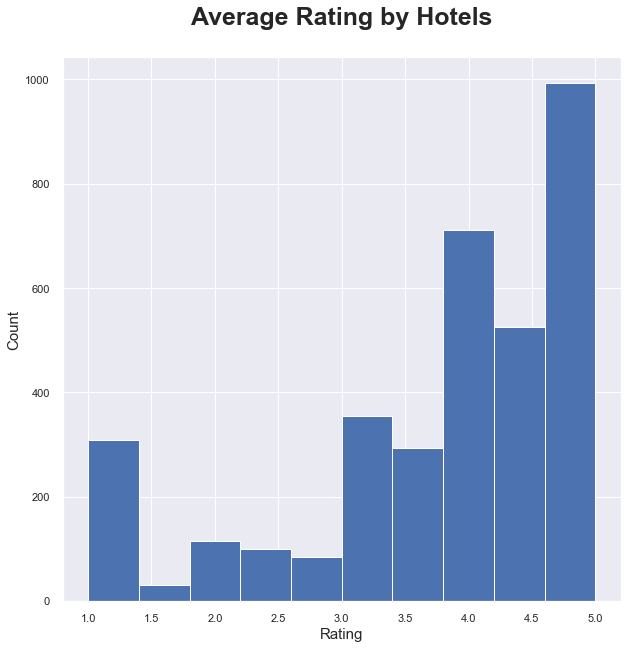

In [31]:
plt.figure(figsize=(10,10))

plt.hist(hotel_avg_ratings['rating'], density = False, 
         histtype ='bar')

plt.xlabel('Rating', fontdict = {'fontsize' : 15})
plt.ylabel('Count', fontdict = {'fontsize' : 15})
 
plt.title('Average Rating by Hotels\n',
          fontweight ="bold", fontdict = {'fontsize' : 25})
  
plt.show()

We want to sort the dataframe by average rating, so that we can show the five hotels with highest ratings and five hotels with lowest ratings

In [32]:
hotel_avg_ratings.nlargest(5, 'rating')

rating  num_ratings
name                                                     
1906 Lodge At Coronado Beach             5.0            1
250 Main Hotel                           5.0            2
AC Hotel Miami Beach                     5.0            1
AC Hotel by Marriott Boston Downtown     5.0            1
Acadia Suites                            5.0            2

In [33]:
hotel_avg_ratings.nsmallest(5, 'rating')

rating  num_ratings
name                                         
11th Avenue Hotel Hostel     1.0            1
A Swallow's Nest Motel       1.0            1
Admiral's Ocean Inn          1.0            2
Adria Motor Inn              1.0            1
Advance Motel                1.0            1

We see that the five hotels with lowest ratings all have ratings of 0.0 and the five hotels with highest ratings all have ratings of 5.0. 
<p>We also see that all these hotels with "lowest" and "highest" ratings only have 1 rating. 
<p>We investigate this further

In [34]:
print("Number of hotels with more than 1 rating:", hotel_avg_ratings[hotel_avg_ratings['num_ratings'] >1].shape[0])
print("Number of hotels with more than 2 ratings:", hotel_avg_ratings[hotel_avg_ratings['num_ratings'] >2].shape[0])


Number of hotels with more than 1 rating: 2305
Number of hotels with more than 2 ratings: 1768


In [35]:
print("Number of hotels with 1 rating:", hotel_avg_ratings[hotel_avg_ratings['num_ratings'] ==1].shape[0])
print("Number of hotels with less than 2 ratings:", hotel_avg_ratings[hotel_avg_ratings['num_ratings'] <= 2].shape[0])

Number of hotels with 1 rating: 1212
Number of hotels with less than 2 ratings: 1749


In [36]:
print("Number of hotels with more than 5 ratings:", hotel_avg_ratings[hotel_avg_ratings['num_ratings'] >5].shape[0])

Number of hotels with more than 5 ratings: 1158


If we were to only consider hotels with at least 5 ratings, the top and bottom hotels are as followed:

In [37]:
hotel_avg_ratings[hotel_avg_ratings['num_ratings'] > 5].nlargest(5, 'rating')

rating  num_ratings
name                                                   
Aloft Philadelphia Downtown            5.0           16
Arrowhead Motel and Rv Park            5.0           11
Bardessono                             5.0            8
Chocolate Turtle Bed and Breakfast     5.0           15
Cougar Crest Lodge                     5.0           10

In [38]:
hotel_avg_ratings[hotel_avg_ratings['num_ratings'] > 5].nsmallest(5, 'rating')

rating  num_ratings
name                                          
The Litchfield Inn       1.000000           13
Norwood Inn and Suites   1.446154           65
Fiesta Inn and Suites    1.454212          546
Seattle Pacific Hotel    1.461538           13
Deluxe Inn Merrillville  1.571429            7

<AxesSubplot:>

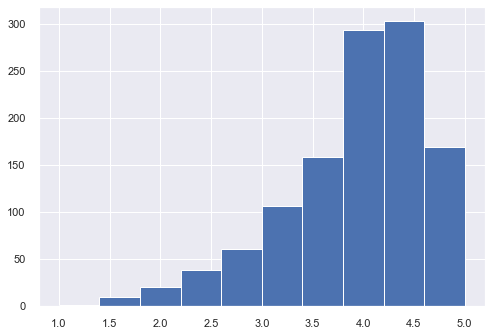

In [39]:
hotel_avg_ratings[hotel_avg_ratings['num_ratings'] > 5]['rating'].hist()

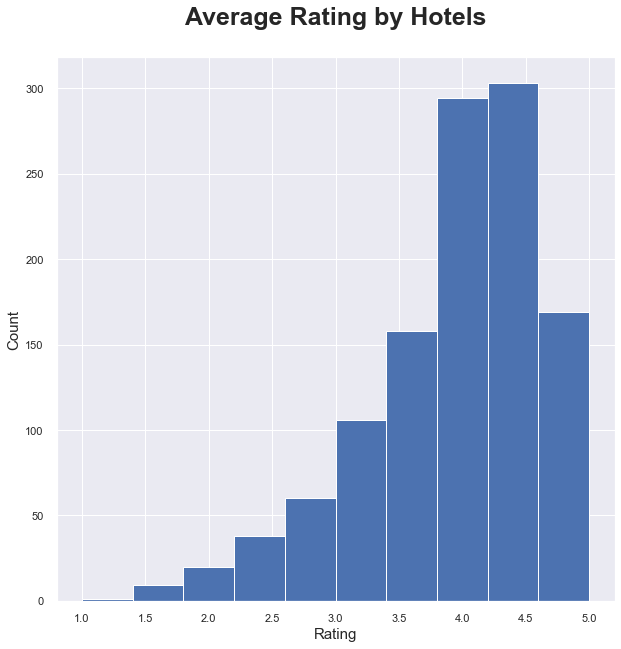

In [40]:
plt.figure(figsize=(10,10))

plt.hist(hotel_avg_ratings[hotel_avg_ratings['num_ratings'] > 5]['rating'], density = False, 
         histtype ='bar')

plt.xlabel('Rating', fontdict = {'fontsize' : 15})
plt.ylabel('Count', fontdict = {'fontsize' : 15})
 
plt.title('Average Rating by Hotels\n',
          fontweight ="bold", fontdict = {'fontsize' : 25})
  
plt.show()

<h2> Hotel Categories </h2>

We start by counting the frequency of hotels categories

In [41]:
hotel_categories= df['categories'].str.split(",").explode()
hotel_categories.value_counts()

Hotels                             46734
Hotel                              27076
Lodging                            11165
Hotels Motels                       8250
Hotels and motels                   6846
                                   ...  
Halls Auditoriums and Ballrooms        1
Carpets and Rugs                       1
Hotel Northgate                        1
Other Personal Services                1
 and Building                          1
Name: categories, Length: 572, dtype: int64

However, we see that some categories clearly overlap (e.g., Hotels and hotel). Thus, we perform some text cleaning to collapse them. In particular, we lowercase and tokenize the category, remove stopwords, and convert each token to its base form via lemmatization. 
<p>In addition, to remove special symbols such as &, we only consider categories that have at least two characters

In [42]:
from nltk.stem.wordnet import WordNetLemmatizer 

nltk.download("stopwords", quiet = True)
lemmatizer = WordNetLemmatizer()
english_stopwords = set(nltk.corpus.stopwords.words('english'))

def clean_category(text):
    return [
        lemmatizer.lemmatize(token)
        for token in nltk.word_tokenize(text.lower())
        if token not in english_stopwords and len(token) > 1
    ]

hotel_categories = hotel_categories.apply(clean_category).explode()

Plotting the top ten categories

<AxesSubplot:>

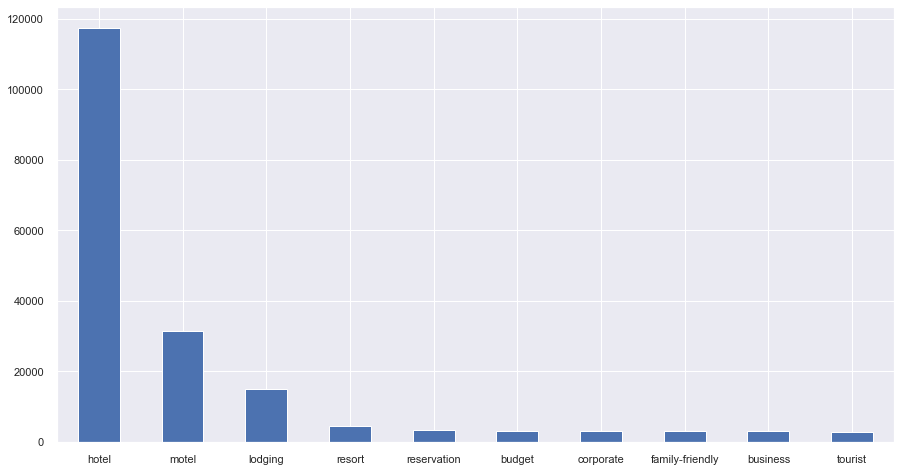

In [43]:
hotel_categories.value_counts().nlargest(10).plot(kind = "bar", rot = 0, figsize = (15, 8))

Showing the 10 most common hotel categories, we see that after hotel, motel and lodging on one hand and resort on another hand are also quite popular

In [44]:
hotel_categories.value_counts().nlargest(10)

hotel              117491
motel               31464
lodging             14829
resort               4337
reservation          3280
budget               3191
corporate            3186
family-friendly      3150
business             3023
tourist              2663
Name: categories, dtype: int64

<h2> Analysing Reviews</h2>

<h3> Reviews categories by ratings </h3>

In [64]:
rating_categories = ["Very bad", "Moderately bad", "Neutral", "Moderately good", "Very good"]
df['rating_category'] = df['rating'].apply(lambda r: rating_categories[int(r) - 1])

Text(0, 0.5, 'Count')

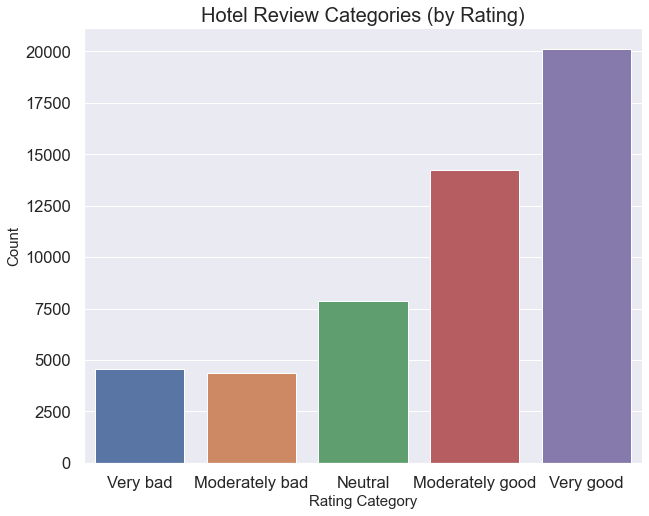

In [65]:
import seaborn as sns
plt.rcParams['figure.figsize'] = [10, 8]
sns.countplot(df.rating_category, order = rating_categories)
plt.title("Hotel Review Categories (by Rating)", fontsize = 20)
plt.xlabel("Rating Category", fontsize = 15)
plt.ylabel("Count", fontsize = 15)

<h3> Review dates </h3>

Presumably people would write their review to a hotel shortly after their stay, so looking at the review count at a particular time would provide some insights into a hotel's traffic at that time.

In [66]:
df['month'] = pd.to_datetime(df['date']).dt.month

In [67]:
df.groupby('month').size()

month
1.0     2956
2.0     3020
3.0     3765
4.0     4172
5.0     4721
6.0     5323
7.0     6729
8.0     5673
9.0     4484
10.0    4439
11.0    2867
12.0    2726
dtype: int64

Text(0, 0.5, 'Count')

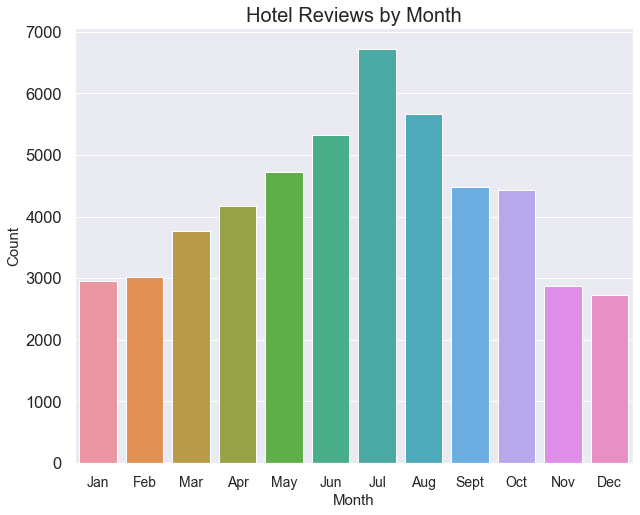

In [68]:
import seaborn as sns
x = [0,1,2,3,4,5,6,7,8,9,10,11]
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
plt.rcParams['figure.figsize'] = [10, 8]
sns.countplot(df.month)
plt.title("Hotel Reviews by Month", fontsize = 20)
plt.xlabel("Month", fontsize = 15)
plt.xticks(x,labels=months,fontsize=14)
plt.ylabel("Count", fontsize = 15)

---------We see that the three clear modes are in January, July, and December. These three months correspond to the New Year holiday, summer holiday, and Christmas, so it makes sense that they yielded the highest number of guests and reviews.--------

We see summer holodays yield the highest number of guests and reviews.

In [69]:
#NEED TO GET FOR EACH MONTH THE MAXI NO OF REVIEWS CAME FROM WHICH CATEGORY

<h3> Distribution of ratings by month </h3>

Trying to see if the ratings tend to be higher at certain times of the year than at other times

In [70]:
month_rating_grouped = df.groupby(['month', 'rating'])
month_rating_grouped.size().unstack()

rating   1.00  1.25  1.30  1.45  1.50  1.65  1.90   2.00  2.10  2.30  ...  \
month                                                                 ...   
1.0     172.0   NaN   NaN   NaN   5.0   1.0   NaN  197.0   NaN   2.0  ...   
2.0     216.0   NaN   NaN   1.0   5.0   NaN   NaN  198.0   1.0   1.0  ...   
3.0     317.0   2.0   NaN   NaN   3.0   1.0   NaN  258.0   3.0   1.0  ...   
4.0     327.0   NaN   1.0   1.0   3.0   2.0   NaN  327.0   NaN   NaN  ...   
5.0     362.0   NaN   NaN   2.0   1.0   1.0   NaN  336.0   3.0   3.0  ...   
6.0     507.0   1.0   NaN   3.0   5.0   NaN   NaN  425.0   NaN   3.0  ...   
7.0     656.0   NaN   NaN   NaN  10.0   NaN   2.0  594.0   2.0   1.0  ...   
8.0     529.0   NaN   NaN   NaN   9.0   NaN   1.0  509.0   1.0   1.0  ...   
9.0     390.0   NaN   NaN   NaN   2.0   1.0   NaN  376.0   NaN   2.0  ...   
10.0    354.0   1.0   NaN   NaN   7.0   NaN   NaN  407.0   NaN   2.0  ...   
11.0    204.0   1.0   NaN   NaN   NaN   NaN   NaN  201.0   NaN   NaN  ...   
12.0    206.0   NaN   NaN   NaN   1.0   2.0   1.0  190.0   2.0   NaN  ...   

rating  4.25  4.30  4.40  4.50  4.60  4.70  4.75  4.80  4.90    5.00  
month                                                                 
1.0      1.0  16.0   8.0   5.0  13.0   NaN   NaN  21.0   1.0  1282.0  
2.0      NaN   3.0  12.0   NaN  10.0   NaN   NaN  18.0   NaN  1272.0  
3.0      NaN   1.0  10.0   4.0  23.0   NaN   NaN  23.0   NaN  1567.0  
4.0      NaN   NaN  12.0   NaN  12.0   NaN   NaN  19.0   2.0  1725.0  
5.0      NaN   NaN  12.0   NaN  20.0   NaN   NaN  15.0   2.0  1880.0  
6.0      NaN   NaN  15.0   1.0  12.0   1.0   NaN  25.0   NaN  2019.0  
7.0      NaN   NaN  16.0   NaN  25.0   1.0   1.0  22.0   NaN  2446.0  
8.0      1.0   NaN  12.0   NaN  34.0   1.0   1.0  32.0   1.0  2065.0  
9.0      NaN   NaN   7.0   1.0  17.0   NaN   NaN  19.0   NaN  1780.0  
10.0     NaN   1.0  10.0   1.0  13.0   1.0   NaN  12.0   NaN  1695.0  
11.0     NaN   4.0   4.0   1.0  12.0   1.0   NaN  16.0   NaN  1227.0  
12.0     NaN   1.0  10.0   3.0   8.0   1.0   NaN  13.0   NaN  1172.0  

[12 rows x 44 columns]

It is a bit hard to see the distribution this way, so we can classify the ratings into groups

In [71]:
month_rating_cat_grouped = df.groupby(['month', 'rating_category'])
month_rating_df = month_rating_cat_grouped.size().unstack()[rating_categories]
month_rating_df

rating_category  Very bad  Moderately bad  Neutral  Moderately good  Very good
month                                                                         
1.0                   178             211      413              872       1282
2.0                   222             246      432              848       1272
3.0                   323             292      538             1045       1567
4.0                   334             354      577             1182       1725
5.0                   366             352      757             1366       1880
6.0                   516             441      830             1517       2019
7.0                   668             631     1135             1849       2446
8.0                   539             542      926             1601       2065
9.0                   393             401      688             1222       1780
10.0                  362             437      680             1265       1695
11.0                  205             222      451              762       1227
12.0                  210             210      412              722       1172

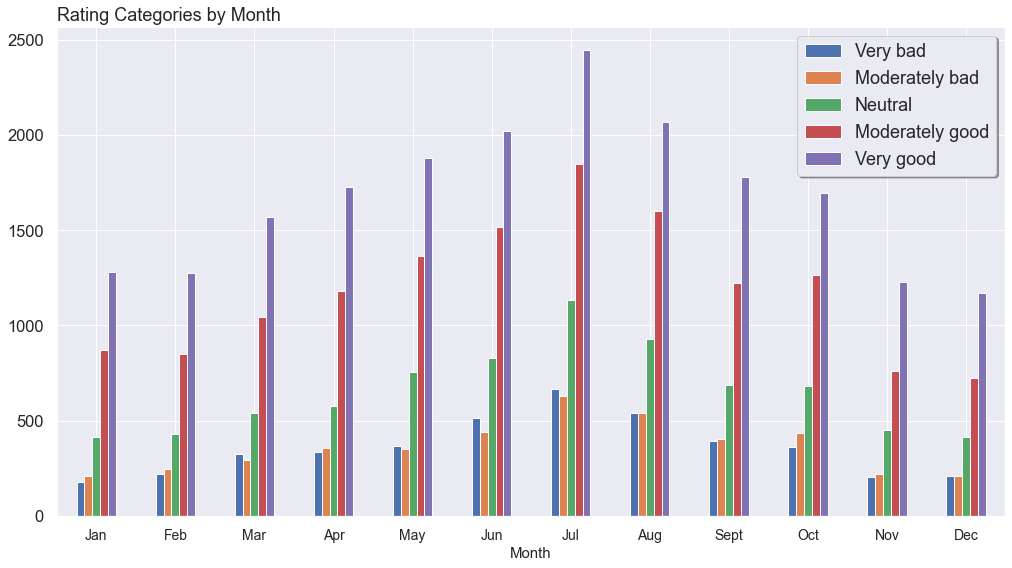

In [72]:
x = [0,1,2,3,4,5,6,7,8,9,10,11]
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
month_rating_df.plot(kind = 'bar', rot = 0, figsize = (17, 9))   
plt.xlabel('Month',fontsize = 15)
plt.xticks(x,labels=months,fontsize=14)
plt.title('Rating Categories by Month',fontsize=18,loc='left')
plt.legend(fontsize='medium', shadow='True', frameon='True')

In [73]:
#NEED TO TAKE A CLOSER LOOK
#Why are there less ratingsa in January & Dec, these are high seasons

----------As we expected from the rating distribution earlier, most reviews are relatively position. Additionally, we can see that even though January, July, and December have the most reviews, July is the month with the most positive reviews. Perhaps this means in the summer, people tend to leave better reviews than other seasons.--------

<h3> Reviews Wordclouds</h3>

## Initial Wordcloud Visualization

In [78]:
def get_reviews(review_list):

    text=''
    for rev in review_list:
        text += rev
    return text

text = get_reviews(df['review'])

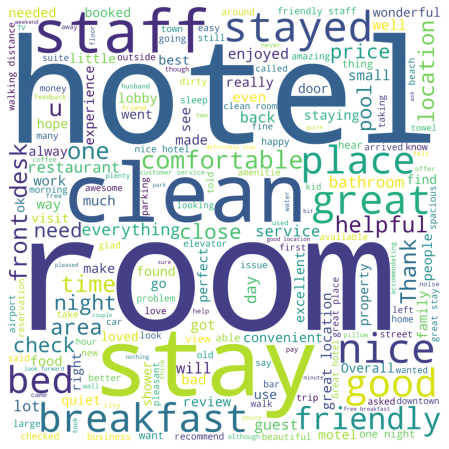

In [79]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white',width = 3000,height = 3000).generate(text)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

We see that the most common words are actually "hotel", "room", and "stay", which makes sense, but does not give us much insights. Thus, we remove these three words and build the word cloud again. Additionally, we want to exclude "I" and "s" which would appear quite often in reviews

In [80]:
def remove_words(text_string, DELETE_WORDS = []):
    text_string = text_string.lower()
    for word in DELETE_WORDS:
        if len(word) == 1: 
            text_string = text_string.replace(' ' + word + ' ',' ')
        else:
            text_string = text_string.replace(word,' ')
    return text_string

def remove_short_words(text_string, min_length = 0):
    word_list = text_string.split()
    for word in word_list:
        if len(word) < min_length:
            text_string = text_string.replace(' ' + word + ' ',' ')
    return text_string

def clean_text(all_reviews):
    text = ''
    for rev in all_reviews:
        text += rev
    text = remove_words(text, ['hotel', 'room', 'stay', 'I', 's', 'ed', 'u', 'b'])
    text = remove_short_words(text, 2)
    return text

Clean reviews

In [81]:
df['review'] = df['review'].apply(lambda x: clean_text(x))

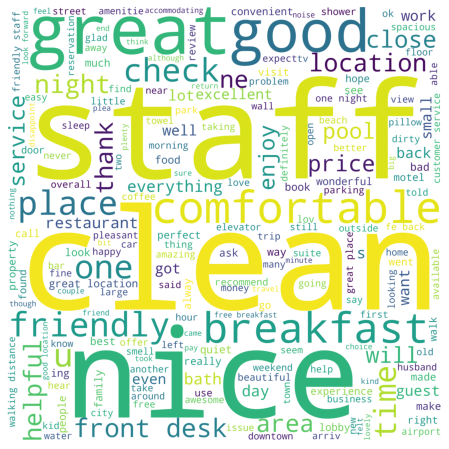

In [82]:
#text = clean_text(df['review'])
text = get_reviews(df['review'])
wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white',width = 3000,height = 3000).generate(text)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

From this we see that many reviews mention "clean" and "staff", suggesting that cleanliness and hotel staffs are something that customers care about.

We also see some mentions of "breakfast", "location", "front desk", etc. These are also some features that customer pay attention to.

Would the word clouds be any different for the very good reviews (rating 5.0) and the very bad reviews (rating 1.0)?

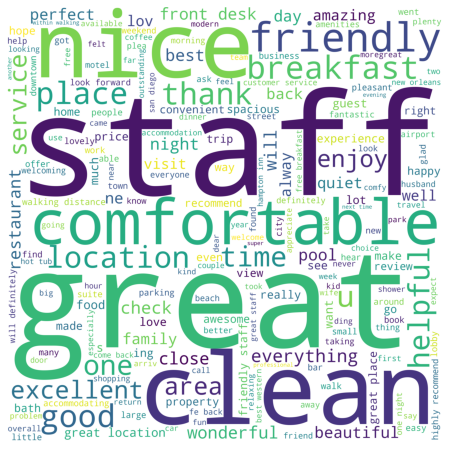

In [83]:
good_reviews = df[df['rating'] == 5.0]['review']

#good_text = clean_text(good_reviews)
good_text = get_reviews(good_reviews)
    
wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white',width = 3000,height = 3000).generate(good_text)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

We can see that the good reviews mention a lot of "clean" and "staff", other than the obvious "great". There are also a lot of mentions of "friendly", "helpful", "comfortable", "convenient", "location", which all hint that the good hotels are the one that are clean and comfortable, with friendly and helpful staff, and at a convenient location.

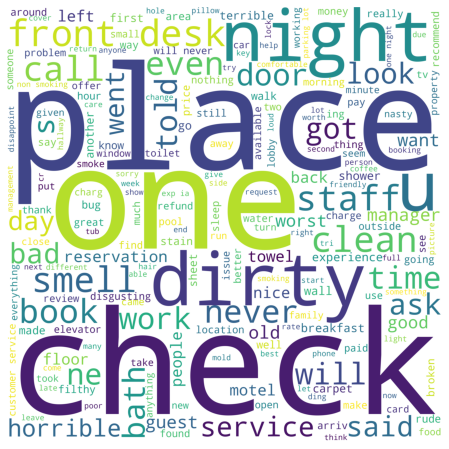

In [84]:
bad_reviews = df[df['rating'] == 1.0]['review']

#bad_text = clean_text(bad_reviews)
bad_text = get_reviews(bad_reviews)

wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white',width = 3000,height = 3000).generate(bad_text)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

On the other hand, the bad reviews are the one about hotels that are "dirty","horrible", "time","booked", or even "smelled".

We can verify these by looking at specific reviews for top hotels and bottom hotels.

<h3> Considering reviews for top hotels and bottom hotels </h3>

To ensure we have enough reviews to generate wordclouds, we consider the 4 best and worst hotels where each hotel has at least 5 reviews

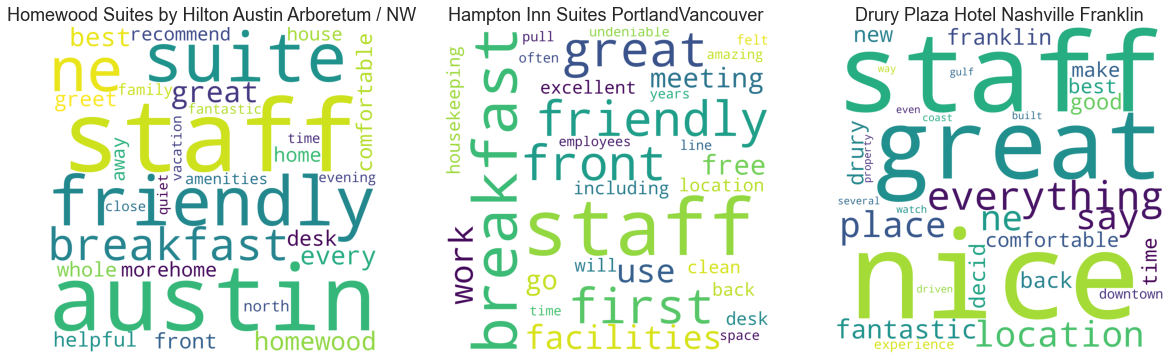

In [85]:
top_hotels_avg_rating = hotel_avg_ratings[hotel_avg_ratings['num_ratings'] > 5].sort_values(by = 'rating', ascending = False).head(3)
top_hotels_avg_rating.reset_index(level=0, inplace=True)
#top_hotels = df[df['name'].isin(top_hotels_avg_rating['name'])]

top_hotels = []

for hotel_name in top_hotels_avg_rating['name']:
    hotel_reviews = df[df['name'] == hotel_name]['review']
    hotel_text = clean_text(hotel_reviews)
    top_hotels.append((hotel_name, hotel_text))
    
#Set up side by side clouds
COL_NUM = 3
ROW_NUM = 1
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i in range(0,len(top_hotels)):
    text_string = top_hotels[i][1]
    
    #ax = axes[i//2, i%2] 
    ax = axes[i] 
    ax.set_title(top_hotels[i][0])
    wordcloud = WordCloud(stopwords = STOPWORDS,background_color='white',width=2000, height=2000,max_words=30).generate(text_string)
    ax.imshow(wordcloud)
    ax.axis('off')
    
plt.show()

In [86]:
bottom_hotels_avg_rating = hotel_avg_ratings[hotel_avg_ratings['num_ratings'] > 5].sort_values(by = 'rating')
bottom_hotels_avg_rating.reset_index(level=0, inplace=True)
bottom_hotels_avg_rating

name    rating  num_ratings
0                                   The Litchfield Inn  1.000000           13
1                               Norwood Inn and Suites  1.446154           65
2                                Fiesta Inn and Suites  1.454212          546
3                                Seattle Pacific Hotel  1.461538           13
4                              Deluxe Inn Merrillville  1.571429            7
...                                                ...       ...          ...
1153  Home2 Suites by Hilton Tallahassee State Capitol  5.000000           10
1154                   Hampton Inn & Suites Dodge City  5.000000            6
1155                             The St. Regis Atlanta  5.000000            7
1156                                Cougar Crest Lodge  5.000000           10
1157                                 The Inn On Negley  5.000000           27

[1158 rows x 3 columns]

In [87]:
df[df['name'] == 'The Litchfield Inn']['text']

9446    stay in the ocean front rooms in the upper tow...
9447    great location, beautiful beach, rooms are all...
9448                             great beach, clean rooms
9449    looking for a retreat location? the oceanfront...
9450    been staying here for years.  enjoy 2nd floor ...
9451    Great location, Beautiful beach, rooms are all...
9452    Been staying here for years.  Enjoy 2nd floor ...
9453                                          nice rooms!
9454                                          Nice rooms!
9455    Stay in the ocean front rooms in the upper tow...
9456                             Great beach, clean rooms
9457    Looking for a retreat location? The Oceanfront...
Name: text, dtype: object

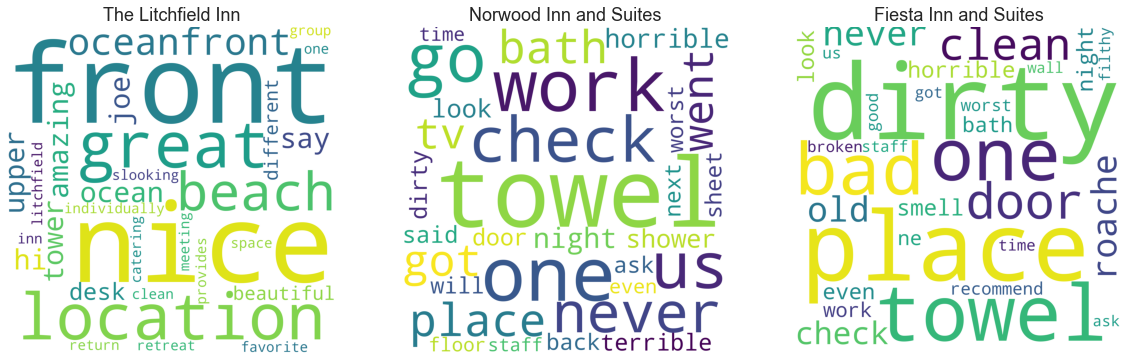

In [88]:
bottom_hotels_avg_rating = hotel_avg_ratings[hotel_avg_ratings['num_ratings'] > 5].sort_values(by = 'rating').head(3)
bottom_hotels_avg_rating.reset_index(level=0, inplace=True)
#bottom_hotels = df[df['name'].isin(bottom_hotels_avg_rating['name'])]

bottom_hotels = []

for hotel_name in bottom_hotels_avg_rating['name']:
    hotel_reviews = df[df['name'] == hotel_name]['review']
    hotel_text = clean_text(hotel_reviews)
    
    bottom_hotels.append((hotel_name, hotel_text))
    
#Set up side by side clouds
COL_NUM = 3
ROW_NUM = 1
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i in range(0,len(bottom_hotels)):
    text_string = bottom_hotels[i][1]
    
    ax = axes[i] 
    ax.set_title(bottom_hotels[i][0])
    wordcloud = WordCloud(stopwords = STOPWORDS,background_color='white',width=2000,height=2000,max_words=30).generate(text_string)
    ax.imshow(wordcloud)
    ax.axis('off')
    
plt.show()

<h3>Review summarzation</h3>

In [89]:
reviews = dict()
for i in range(len(df)):
    if df['name'].iloc[i] in reviews:
        reviews[df['name'].iloc[i]] = reviews[df['name'].iloc[i]] + str(df['review'].iloc[i])
    else: 
        reviews[df['name'].iloc[i]] = str(df['review'].iloc[i])

In [90]:
def get_summarization(hotel_name, reviews = reviews):
    
    text = reviews[hotel_name]
    striptext = text.replace('\n\n', ' ')
    striptext = striptext.replace('\n', ' ')
    
    return gensim.summarization.summarize(striptext, word_count=100)


def draw_wordcloud(summary):
    
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=3000,height=3000).generate(summary)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
    return None

Looking at one of the hotels with low rating

In [91]:
summary = get_summarization('Fiesta Inn and Suites')
print(summary)

and the top of it was death ticks and bugs under mattressthey show  me  and all the same resultsnastyvery bad   the   was in terrible condition the pillows had hair as well as the sheets did not have to ask for towels and soaps because we did not want to bathe because of how dirty all the corridors and stairs were going down and up some very bad looking people in in general, would like that  s.com does not put it in their   catalog because in the photos things appear very different from realitynot what expect  the motel is very old and run down.


In [92]:
summary = get_summarization('The Litchfield Inn')
print(summary)

the oceanfront litchfield inn provides meeting space, catering, group accommodation rates, bus parking and an oceanfront setting with easy access to the grand strand.been  ing here for years.
enjoy 2nd floor "dunes"  especially in fall and spring.great location, beautiful beach,  are all different since they are individually own  so you can get favorite and return to the same one!been  ing here for years.
the oceanfront litchfield inn provides meeting space, catering, group accommodation rates, bus parking and an oceanfront setting with easy access to the grand strand.


Looking at on of the hotels with great ratings

In [93]:
summary = get_summarization('The Inn On Negley')
print(summary)

the chef at the inn is extremely talent  everything for the tea was delicious (especially the scones), as was breakfast the next morning.
morelove their high tea have never actually    at the inn but have tour  many of the  and they are appoint  beautifully.
hot breakfast was excellent and hosts very friendly.great inn close to downtown french toast is amazing.a wonderful and relaxing   only    one night, but check  in at 1:00 pm and left at 11:00 the next day so it wasn't just in to sleep and out again.
as is the cheese plate.holiday in pittsburgh we are  ing at the inn on negley for the fourth time.


the staff is extremely friendly and there's free breakfast in the morning.
the staff is friendly, welcoming and helpful.
the breakfast is excellent and coffee,tea and bottl  water are always available.love hampton love  ing at hampton always nice and clean!kids enjoy  the pool free breakfast was great and staff was so nice highly recommend it to anyone always look for hampton first when we ne    they are reliable for there politeness and cleanslinessfamily trip excellent clean   and friendly staff.
wonderful s, very helpful staff and great breakfast.great  the staff welcom  me as the guest of the day!
the breakfast was good and the   is pretty updat the  was surprisingly super comfortable.


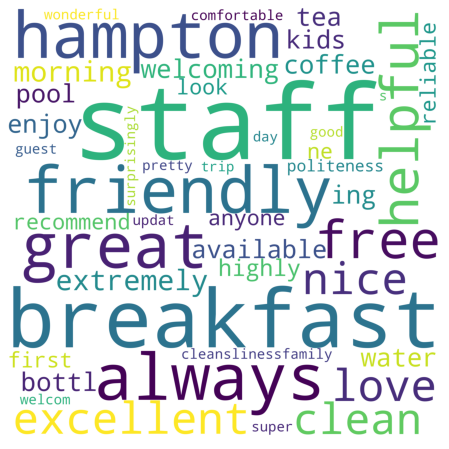

In [94]:
summary = get_summarization('Hampton Inn & Suites Warren')
print(summary)
draw_wordcloud(summary)

For any hotel in the list one can quickly get an undrstanding of what to expect from past customers experiences

the reason we chose to   at 40 berkeley was for the convenient location (2 blocks from the orange subway line and 30 minute walk to the boston common/downtown area) and reasonable price compar  to other  and hostels in boston (130/night for   with double  and shar  bath ).
moregreat location but very basic very nice place!good location, way overpric  we arriv  at 40 berkeley in the middle of october for one night  we had seen it advertis  on hostelworld as trendy hostel in trendy area and given the 138 price tag for shar  bath   were expecting more.


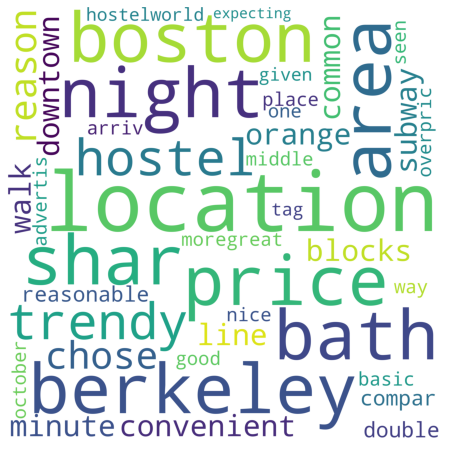

In [95]:
summary = get_summarization('40 Berkeley Hostel')
print(summary)
draw_wordcloud(summary)

<h2> Customer Analysis </h2>

<h3>Segmentation of customer based on reviews using LDA: Latent Dirichlet Allocation Model</h3>

<li>Import all necessary libraries
<li>Review document preparation
<li>Cleaning the data
<li>Building and running the model
<li>Result display and interpretation

<h4>Importing necessary libraries </h4>

In [96]:
import nltk
from nltk import sent_tokenize,word_tokenize 
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem.porter import PorterStemmer
import pprint

<h4>Data preparation and cleaning</h4>

In [97]:
review_list =list()
for review in df['review']: 
    review = clean_text(review)
    review_list.append(review)

In [98]:
for i in range(len(review_list)):
    review = review_list[i]
    sents = sent_tokenize(review)
    for j in range(len(sents)):
        sent = sents[j]
        sent = sent.strip().replace('\n','')
        sents[j] = sent
    review_list[i] = '. '.join(sents)

In [99]:
p_stemmer = PorterStemmer()
for review in review_list[:-1]:
    words = word_tokenize(review)
    review_list[i] =  nltk.Text([p_stemmer.stem(i).lower() for i in words])

In [100]:
no_list = ['la', 'en', 'y', 'et', 'le', 'que', 'el', 'e', 'und', 'es', 'stay', 'stayed','staying','san', 'est', 'muy', 'trs', 'les', 'die', 'las', 'il', 'das', 'para']
texts = [[word for word in review.lower().split()
        if word not in STOPWORDS and word.isalnum() and word not in no_list and not word.lower() == 'hotel']
        for review in review_list[:-1]]

<h4>Building and implementing the model</h4>

In [101]:
def lda_modeling(texts,num_topics=3,passes = 15):
    #Building a model
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    #Implementing the model
    lda = LdaModel(corpus,
              id2word=dictionary,
              num_topics=num_topics,
              passes=passes)
    return lda,corpus,dictionary

In [102]:
lda,corpus,dictionary = lda_modeling(texts)

<h4>Results Interpretation</h4>

Candidate topics in the form of words

In [103]:
pp = pprint.PrettyPrinter(indent=5)
pp.pprint(lda.print_topics(num_words=20))

[    (    0,
          '0.035*"nice" + 0.032*"good" + 0.030*"great" + 0.029*"breakfast" + '
          '0.025*"clean" + 0.020*"staff" + 0.017*"location" + 0.014*"friendly" '
          '+ 0.013*"place" + 0.012*"close" + 0.011*"comfortable" + '
          '0.010*"free" + 0.009*"ne" + 0.009*"area" + 0.008*"pool" + '
          '0.007*"price" + 0.007*"little" + 0.007*"parking" + 0.006*"night" + '
          '0.006*"small"'),
     (    1,
          '0.012*"check" + 0.011*"desk" + 0.009*"like" + 0.008*"bath" + '
          '0.008*"night" + 0.008*"ne" + 0.007*"got" + 0.007*"book" + '
          '0.006*"ask" + 0.005*"time" + 0.005*"door" + 0.005*"told" + '
          '0.005*"shower" + 0.005*"floor" + 0.005*"smell" + 0.005*"went" + '
          '0.004*"arriv" + 0.004*"people" + 0.004*"bad" + 0.004*"work"'),
     (    2,
          '0.025*"great" + 0.020*"staff" + 0.014*"time" + 0.013*"enjoy" + '
          '0.011*"best" + 0.010*"service" + 0.008*"thank" + 0.008*"visit" + '
          '0.007*"wonderful" + 

Wordcloud for the topics

In [104]:
def draw_wordcloud(lda,num_topics,min_size=0,STOPWORDS=[],max_words=30):
    
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    %matplotlib inline
    from random import shuffle
        
    COL_NUM = num_topics
    ROW_NUM = 1
    fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

    
    for i in range(num_topics):
        word_list=[]
        prob_total = 0
        for word,prob in lda.show_topic(i,topn=50):
            prob_total +=prob
        for word,prob in lda.show_topic(i,topn=50):
            if word in STOPWORDS or  len(word) < min_size:
                continue
    #         freq = int(prob/prob_total*1000)
            freq = int(prob/prob_total*100)
            alist=[word]
            word_list.extend(alist*freq)
        
        shuffle(word_list)
        text = ' '.join(word_list)

        ax = axes[i] 
        ax.set_title(lda.show_topics()[i][0])
        wordcloud = WordCloud(stopwords = STOPWORDS,background_color='white',height = 2000, width = 2000,max_words=max_words).generate(text)
        ax.imshow(wordcloud)
        ax.axis('off') 
        
    return None

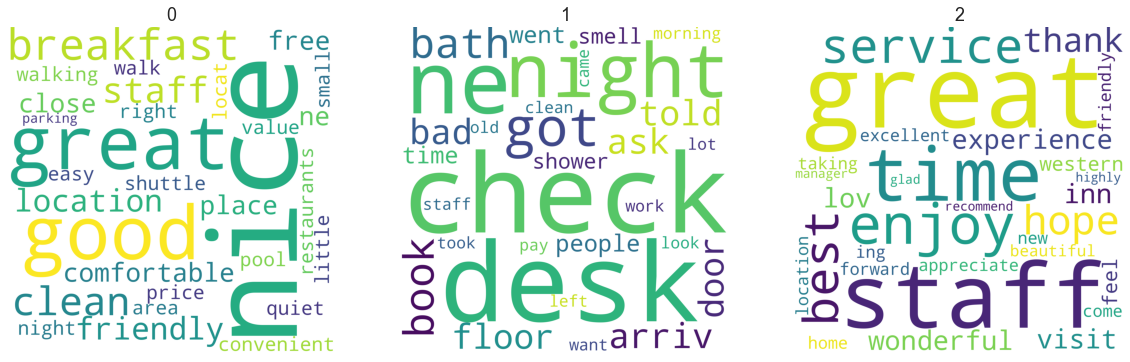

In [105]:
draw_wordcloud(lda, 3)

Intertopic Distance Map (via multidimensional scaling)

In [106]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
lda_display = gensimvis.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

There are three types of reviews showing interests in different areas

<li> Location : Views, beauty, scenes
<li> Service : Friendly, appreciation, time, experience
<li> Facilities: Rooms, cleanliness, breakfast

# Feature Engineering (Text Mining)

The only data we have is the short text extract. So, we will use several text mining technics in order to extract useful features.

## Normalization and cleaning functions

In [107]:
# Normalization over number of words
def normalization_word(var):
    """Returns number of words."""
    words = nltk.Text(word_tokenize(((var))))
    return len(words)

# Normalization by number of Sentences
def normalization_sentence(var):
    """Returns number of sentences."""
    sentences = nltk.Text(sent_tokenize(var))
    return len(sentences)

# Normalization by number of Characters
def normalization_character(var):
    """Returns number of characters."""
    return len(var)

def cleaning(var):
    """Take a string. Returns a string with only lowercase letters and the space between words."""
    plain_string = ""
    for x in var:
        x = x.lower()
        if (('a' <= x and x <= 'z') or x == ' '):
            plain_string += x
        elif x == '\'':  # any apostrophes(') are replaced by a space
            plain_string += ' '
    while '  ' in plain_string:  # any multiple spaces are replaced by a single space
        plain_string = plain_string.replace('  ', ' ')
    return plain_string

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Meta Features: the form of the text

These are the features related to the form of the text:

    Sentence length (characters & words)
    Word length
    Percentage of unique words
    Stopword count
    Emphases on words or phrases
    
These features don't take into account the substance. It is only about the structure

In [108]:
# Average sentence length (in characters)
def length_character(var):
    """Takes a string returns an int (average sentence length in characters)."""
    return len(var) / normalization_sentence(var)
# Average sentence length (in words)
def length_sentence(var):
    """Takes a string and returns an int (average sentence length in words)."""
    return len(var.split()) / normalization_sentence(var)
# Average characters per word
def length_word(var):
    """Takes a string and returns an int (average characters per word). Excludes punctuations."""
    return len(var.split()) / normalization_word(var)


C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Percentage of unique words per sentence
This feature demonstrates the richness of vocabulary.

In [109]:
def vocabulary_sentence(var):
    """Takes a string and returns the ratio of different words to all words."""
    var = nltk.Text(sent_tokenize(var))
    vocabulary_list = []
    for c in var:
        if normalization_word(c) != 0:
            vacabulary_count_sentence = len({x.lower() for x in word_tokenize(cleaning(c))})
            vocabulary_list.append(vacabulary_count_sentence / normalization_word(c))
    return np.mean(vocabulary_list)

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Stopword percentage
Stopwords are common basic english word. It is also a metric of the richness of the vocabulary.

In [110]:
def density_stopword(var):
    """Takes a string and returns the ratio of stopwords to all words."""
    cs = 0
    for x in nltk.Text(word_tokenize(var)):
        if x in STOPWORDS:
            cs += 1
    return cs/normalization_word(var)

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Building of the Dataframe of Metadata
This is the list of all the meta data we are going to use to train our models. We are also going to use bag of words. This could be modified if we add meta data.

In [111]:
def build_meta(dataframe):
    """Builds a dataframe that shows the author and the other meta-data related to the sentence."""
    df_meta = dataframe.copy()
    list_meta = [length_character,
             length_sentence,
             length_word,  
             vocabulary_sentence,
             density_stopword
            ]
    for f in list_meta:
        df_meta[f.__name__] = df_meta.text.apply(f)
    return df_meta 

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [113]:
from nltk import sent_tokenize, word_tokenize, FreqDist
df = build_meta(df)

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Text Features: substance of the text
Now, let's dive into the study of text-features: the study of the substance of the text.

## Emotions
The following function needs to have the file "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt" in the same folder. Based on NRC data: 8 emotions

Emotion analysis attributes emotional score for each extract and then build n-features (number of studied emotions).

    'positive'
    'anger'
    'disgust'
    'fear'
    'negative'
    'sadness'
    'anticipation'
    'joy'
    'surprise'
    'trust'

In [117]:
def get_nrc_data():
    """Builds an emotion dictionary from the NRC emotion lexicon."""
    nrc = "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
    count = 0
    emotion_dict = dict()
    with open(nrc,'r') as f:
        all_lines = list()
        for line in f:
            if count < 46:
                count += 1
                continue
            line = line.strip().split('\t')
            if int(line[2]) == 1:
                if emotion_dict.get(line[0]):
                    emotion_dict[line[0]].append(line[1])
                else:
                    emotion_dict[line[0]] = [line[1]]
    return emotion_dict

def emotions(dataframe):
    """Takes a dataframe and creates a column per emotion with a count on the emotions used."""
    df = dataframe.copy()
    emotions=['positive','anger','disgust','fear','negative','sadness','anticipation','joy','surprise','trust']
    for emotion in emotions:
        df[emotion]=0
    
    emotion_dic = get_nrc_data()
    for i in range(len(df)):
        words = df['review'].iloc[i].split()
        n = len(words)
        for word in words:
            if word in emotion_dic:
                for emotion in emotion_dic[word]:
                    column = emotion
                    try:
                        df[column].iloc[i] = df[column].iloc[i] + 1 / n
                    except:
                        pass
    return df

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [118]:
#add NRC emotions
df = emotions(df)

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Vader analysis: Positivity/Negativity
Vader contains a list of 7500 features weighted by how positive or negative they are It uses these features to calculate stats on how positive, negative and neutral a passage is and combines these results to give a compound sentiment (higher = more positive) for the passage.

    Human trained on twitter data and generally considered good for informal communication

    10 humans rated each feature in each tweet in context from -4 to +4

    Calculates the sentiment in a sentence using word order analysis

    "marginally good" will get a lower positive score than "extremely good"

    Computes a "compound" score based on heuristics (between -1 and +1)

    Includes sentiment of emoticons, punctuation, and other 'social media' lexicon elements

In [119]:
def vader_analysis(texts):
    analyzer = SentimentIntensityAnalyzer()
    result = dict()
    keys = ['vader_pos', 'vader_compound', 'vader_neu', 'vader_neg']
    for k in keys:
        result[k] = 0
        
    sentences = sent_tokenize(texts)
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        result['vader_pos'] += vs['pos']/(len(sentences))
        result['vader_compound'] += vs['compound']/(len(sentences))
        result['vader_neu'] += vs['pos']/(len(sentences))
        result['vader_neg'] += vs['neg']/(len(sentences))
        
    return result

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [120]:
vader_results = df['review'].apply(vader_analysis).apply(pd.Series)
df = pd.concat([df,vader_results],axis=1)

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [121]:
df

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


address  \
60     435 E Avenida Olancha   
61     435 E Avenida Olancha   
62     435 E Avenida Olancha   
63     435 E Avenida Olancha   
64     435 E Avenida Olancha   
...                      ...   
55906       215 S Pacific St   
55907       215 S Pacific St   
55908           669 Route 6a   
55909     702 W Appleway Ave   
55910    2295 N Highland Ave   

                                              categories            city  \
60                                          Hotels,Hotel    Palm Springs   
61                                          Hotels,Hotel    Palm Springs   
62                                          Hotels,Hotel    Palm Springs   
63                                          Hotels,Hotel    Palm Springs   
64                                          Hotels,Hotel    Palm Springs   
...                                                  ...             ...   
55906                        Hotel,Hotels,Lodging,Motels  Rockaway Beach   
55907                        Hotel,Hotels,Lodging,Motels  Rockaway Beach   
55908                                       Hotel,Hotels   East Sandwich   
55909  Hotel,Hotel, Motel, and Building,Hotels,Lodgin...   Coeur d'Alene   
55910  Hotel,Hotels Motels,Budget Hotels,Hotels & Motels         Jackson   

      country   latitude  longitude                              name  \
60         US  33.802822 -116.54269             Little Paradise Hotel   
61         US  33.802822 -116.54269             Little Paradise Hotel   
62         US  33.802822 -116.54269             Little Paradise Hotel   
63         US  33.802822 -116.54269             Little Paradise Hotel   
64         US  33.802822 -116.54269             Little Paradise Hotel   
...       ...        ...        ...                               ...   
55906      US  45.611260 -123.94556     Silver Sands Oceanfront Motel   
55907      US  45.611260 -123.94556     Silver Sands Oceanfront Motel   
55908      US  41.729390  -70.39925                  Sandy Neck Motel   
55909      US  47.699930 -116.79690  Shilo Inn Suites - Coeur d'Alene   
55910      US  35.666390  -88.83012                      Scottish Inn   

       postalCode province                      date  ...  negative   sadness  \
60          92264       CA      2016-02-19T00:00:00Z  ...  0.000000  0.000000   
61          92264       CA      2016-06-25T00:00:00Z  ...  0.000000  0.000000   
62          92264       CA      2016-08-01T00:00:00Z  ...  0.000000  0.032787   
63          92264       CA      2016-06-08T00:00:00Z  ...  0.000000  0.017544   
64          92264       CA      2016-03-17T00:00:00Z  ...  0.016949  0.016949   
...           ...      ...                       ...  ...       ...       ...   
55906  97136-9596       OR      2016-07-01T00:00:00Z  ...  0.019608  0.000000   
55907  97136-9596       OR      2016-03-13T00:00:00Z  ...  0.000000  0.000000   
55908  02537-1472       MA      2015-12-11T00:00:00Z  ...  0.017544  0.017544   
55909  83814-9338       ID  2017-11-17T00:00:00.000Z  ...  0.000000  0.021739   
55910  38305-4922       TN      2016-06-09T00:00:00Z  ...  0.054545  0.018182   

      anticipation       joy  surprise     trust vader_pos vader_compound  \
60        0.000000  0.000000  0.000000  0.016667  0.249500       0.318583   
61        0.033898  0.050847  0.033898  0.050847  0.396667       0.536000   
62        0.016393  0.016393  0.000000  0.032787  0.436333       0.359267   
63        0.052632  0.087719  0.035088  0.052632  0.412200       0.776460   
64        0.033898  0.067797  0.033898  0.067797  0.380600       0.573560   
...            ...       ...       ...       ...       ...            ...   
55906     0.039216  0.098039  0.019608  0.039216  0.380600       0.452020   
55907     0.016667  0.033333  0.016667  0.033333  0.234500       0.300350   
55908     0.035088  0.035088  0.035088  0.017544  0.229200       0.398620   
55909     0.000000  0.000000  0.000000  0.000000  0.323500       0.505450   
55910     0.000000  0.0000

<h2> Vader Sentiment Analysis </h2>

In [122]:
import nltk
from nltk import sent_tokenize,word_tokenize 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [123]:
def vader_comparison(texts,names):
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    import pandas as pd
    vdr_df = pd.DataFrame(columns=['Hotel','Positive','Negative','Neutral','Compound'])
   
    output = vdr_df
    analyzer = SentimentIntensityAnalyzer()
    for i in range(len(df)):
        hotel = names.iloc[i]
        text = texts.iloc[i]
        sentences = sent_tokenize(text)
        pos=compound=neu=neg=0
        for sentence in sentences:
            vs = analyzer.polarity_scores(sentence)
            pos+=vs['pos']/(len(sentences))
            compound+=vs['compound']/(len(sentences))
            neu+=vs['neu']/(len(sentences))
            neg+=vs['neg']/(len(sentences))
            
        vdr_df = vdr_df.append({'Hotel':hotel, 'Positive':pos,'Negative':neg,'Neutral':neu,'Compound':compound},ignore_index=True)
        
    return vdr_df

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [124]:
# Vader analysis of just the reviews (excluding the titles)
reviews_polarity=vader_comparison(df['text'],df['name'])  
reviews_polarity

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Hotel  Positive  Negative   Neutral  \
0                 Little Paradise Hotel  0.138833  0.000000  0.861167   
1                 Little Paradise Hotel  0.249333  0.000000  0.750667   
2                 Little Paradise Hotel  0.092500  0.093000  0.815000   
3                 Little Paradise Hotel  0.409800  0.000000  0.590200   
4                 Little Paradise Hotel  0.342400  0.023800  0.634000   
...                                 ...       ...       ...       ...   
50925     Silver Sands Oceanfront Motel  0.378000  0.000000  0.622000   
50926     Silver Sands Oceanfront Motel  0.205143  0.019286  0.775571   
50927                  Sandy Neck Motel  0.169200  0.000000  0.830800   
50928  Shilo Inn Suites - Coeur d'Alene  0.323500  0.000000  0.676500   
50929                      Scottish Inn  0.000000  0.000000  1.000000   

       Compound  
0      0.206983  
1      0.586633  
2      0.009500  
3      0.780320  
4      0.529060  
...         ...  
50925  0.464150  
50926  0.254729  
50927  0.254940  
50928  0.505450  
50929  0.000000  

[50930 rows x 5 columns]

In [125]:
# Vader analysis of just the titles
title_polarity=vader_comparison(df['title'],df['name'])  
title_polarity

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Hotel  Positive  Negative  Neutral  Compound
0                 Little Paradise Hotel    0.6000       0.0   0.4000   0.66960
1                 Little Paradise Hotel    0.8070       0.0   0.1930   0.63600
2                 Little Paradise Hotel    0.7915       0.0   0.2085   0.54015
3                 Little Paradise Hotel    0.0000       0.0   1.0000   0.00000
4                 Little Paradise Hotel    0.7250       0.0   0.2750   0.83560
...                                 ...       ...       ...      ...       ...
50925     Silver Sands Oceanfront Motel    0.5000       0.0   0.5000   0.61240
50926     Silver Sands Oceanfront Motel    0.0000       0.0   1.0000   0.00000
50927                  Sandy Neck Motel    0.7500       0.0   0.2500   0.71840
50928  Shilo Inn Suites - Coeur d'Alene    0.0000       0.0   1.0000   0.00000
50929                      Scottish Inn    0.0000       1.0   0.0000  -0.47670

[50930 rows x 5 columns]

In [126]:
# Vader analysis of both the review and the title
all_polarity=vader_comparison(df['review'],df['name'])  
all_polarity

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Hotel  Positive  Negative   Neutral  \
0                 Little Paradise Hotel  0.249500  0.000000  0.750500   
1                 Little Paradise Hotel  0.396667  0.000000  0.603333   
2                 Little Paradise Hotel  0.436333  0.046333  0.517333   
3                 Little Paradise Hotel  0.412200  0.000000  0.587800   
4                 Little Paradise Hotel  0.380600  0.025000  0.594400   
...                                 ...       ...       ...       ...   
50925     Silver Sands Oceanfront Motel  0.380600  0.000000  0.619400   
50926     Silver Sands Oceanfront Motel  0.234500  0.006500  0.759000   
50927                  Sandy Neck Motel  0.229200  0.000000  0.770800   
50928  Shilo Inn Suites - Coeur d'Alene  0.323500  0.000000  0.676500   
50929                      Scottish Inn  0.000000  0.053800  0.946200   

       Compound  
0      0.318583  
1      0.536000  
2      0.359267  
3      0.776460  
4      0.573560  
...         ...  
50925  0.452020  
50926  0.300350  
50927  0.398620  
50928  0.505450  
50929 -0.154540  

[50930 rows x 5 columns]

In [127]:
df_vader = df[['name','title','review','rating']]

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [128]:
df_vader

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


name  \
60                Little Paradise Hotel   
61                Little Paradise Hotel   
62                Little Paradise Hotel   
63                Little Paradise Hotel   
64                Little Paradise Hotel   
...                                 ...   
55906     Silver Sands Oceanfront Motel   
55907     Silver Sands Oceanfront Motel   
55908                  Sandy Neck Motel   
55909  Shilo Inn Suites - Coeur d'Alene   
55910                      Scottish Inn   

                                        title  \
60                   Hospitality at its Best!   
61                              Pure delight!   
62        Awesome! Quiet secluded tranquility   
63                  As the title suggests....   
64       Loved this Wonderful Boutique Hotel!   
...                                       ...   
55906  Gorgeous outlook on to beach/water/sun   
55907              Picture Window Ocean View!   
55908            Clean, comfortable and quiet   
55909                         Passing through   
55910                                Terrible   

                                                  review  rating  
60     hospitality at its best! we had wonderful, rel...     5.0  
61     pure delight! we were in palm springs on the d...     5.0  
62     awesome! quiet seclud  tranquility we arriv  i...     5.0  
63     as the title suggests.... this place really is...     5.0  
64     lov  this wonderful boutique  spent nights at ...     5.0  
...                                                  ...     ...  
55906  gorgeous outlook on to beach/water/sun small t...     5.0  
55907  picture window ocean view! it is hard for me t...     3.0  
55908  clean, comfortable and quiet live close by, an...     4.0  
55909  passing through roll  in 11:30 laid out heads ...     4.0  
55910  terrible absolutely terrible..i was told was b...     1.0  

[50930 rows x 4 columns]

In [129]:
df_vader['review polarity'] = reviews_polarity['Compound']
df_vader['title polarity'] = title_polarity['Compound']
df_vader['review and title polarity'] = all_polarity['Compound']

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Rating')

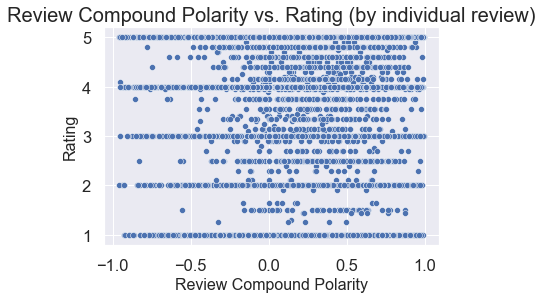

In [130]:
sns.scatterplot(y = "rating", x = "review polarity", data=df_vader)
plt.title("Review Compound Polarity vs. Rating (by individual review)", fontsize = 20)
plt.xlabel('Review Compound Polarity', fontsize=16)
plt.ylabel('Rating', fontsize=16)
# plt.savefig('./Figures/review_rating_polarity.jpg')

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Title Compound Polarity Score')

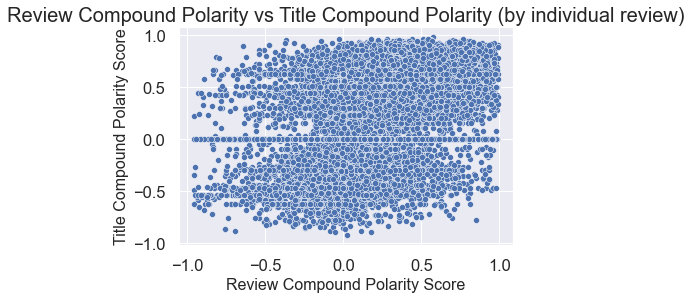

In [131]:
sns.scatterplot(y = "title polarity", x = "review polarity", data=df_vader)
plt.title("Review Compound Polarity vs Title Compound Polarity (by individual review)", fontsize = 20)
plt.xlabel('Review Compound Polarity Score', fontsize=16)
plt.ylabel('Title Compound Polarity Score', fontsize=16)
# plt.savefig('./Figures/review_title_polarity.jpg')

In [132]:
df_grouped = df_vader.groupby('name').mean()

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [133]:
df_grouped['total reviews'] = df_vader.groupby('name').count()['rating']

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [134]:
df_grouped

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


rating  review polarity  title polarity  \
name                                                                           
11th Avenue Hotel Hostel           1.000000         0.421157        0.000000   
1785 Inn                           3.000000         0.522049        0.398360   
1900 House                         4.923077        -0.028131        0.329846   
1906 Lodge At Coronado Beach       5.000000         0.313275        0.624900   
21c Museum Hotel Lexington         2.500000         0.531630        0.361650   
...                                     ...              ...             ...   
Ye Olde Danish Inn                 5.000000         0.410333        0.623900   
Z Bar Motel                        4.000000         0.383745        0.747400   
dana hotel and spa                 4.482609         0.270424        0.321974   
hampton inn Springfield southeast  5.000000         0.487725        0.736500   
hotel le bleu                      4.333333         0.387608        0.185433   

                                   review and title polarity  total reviews  
name                                                                         
11th Avenue Hotel Hostel                            0.421157              1  
1785 Inn                                            0.650718             15  
1900 House                                          0.176420             13  
1906 Lodge At Coronado Beach                        0.485500              1  
21c Museum Hotel Lexington                          0.577340              2  
...                                                      ...            ...  
Ye Olde Danish Inn                                  0.445367              1  
Z Bar Motel                                         0.463906              2  
dana hotel and spa                                  0.342316             46  
hampton inn Springfield southeast                   0.707842              2  
hotel le bleu                                       0.512217              3  

[3302 rows x 5 columns]

In [135]:
def polarity_binning(x):
    if x < -.4:
        return "Terrible"
    elif x < -.1:
        return "Bad"
    elif x < .1:
        return "Neutral"
    elif x < .5:
        return "Good"
    else:
        return "Great"

get_polarity = lambda x: polarity_binning(x)

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [136]:
df_grouped["polarity_bin"] = df_grouped['review polarity'].apply(get_polarity)

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [137]:
df_grouped["popularity"] = df_grouped["rating"] * df_grouped["total reviews"]

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [138]:
df_grouped

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


rating  review polarity  title polarity  \
name                                                                           
11th Avenue Hotel Hostel           1.000000         0.421157        0.000000   
1785 Inn                           3.000000         0.522049        0.398360   
1900 House                         4.923077        -0.028131        0.329846   
1906 Lodge At Coronado Beach       5.000000         0.313275        0.624900   
21c Museum Hotel Lexington         2.500000         0.531630        0.361650   
...                                     ...              ...             ...   
Ye Olde Danish Inn                 5.000000         0.410333        0.623900   
Z Bar Motel                        4.000000         0.383745        0.747400   
dana hotel and spa                 4.482609         0.270424        0.321974   
hampton inn Springfield southeast  5.000000         0.487725        0.736500   
hotel le bleu                      4.333333         0.387608        0.185433   

                                   review and title polarity  total reviews  \
name                                                                          
11th Avenue Hotel Hostel                            0.421157              1   
1785 Inn                                            0.650718             15   
1900 House                                          0.176420             13   
1906 Lodge At Coronado Beach                        0.485500              1   
21c Museum Hotel Lexington                          0.577340              2   
...                                                      ...            ...   
Ye Olde Danish Inn                                  0.445367              1   
Z Bar Motel                                         0.463906              2   
dana hotel and spa                                  0.342316             46   
hampton inn Springfield southeast                   0.707842              2   
hotel le bleu                                       0.512217              3   

                                  polarity_bin  popularity  
name                                                        
11th Avenue Hotel Hostel                  Good         1.0  
1785 Inn                                 Great        45.0  
1900 House                             Neutral        64.0  
1906 Lodge At Coronado Beach              Good         5.0  
21c Museum Hotel Lexington               Great         5.0  
...                                        ...         ...  
Ye Olde Danish Inn                        Good         5.0  
Z Bar Motel                               Good         8.0  
dana hotel and spa                        Good       206.2  
hampton inn Springfield southeast         Good        10.0  
hotel le bleu                             Good        13.0  

[3302 rows x 7 columns]

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Text review categories')

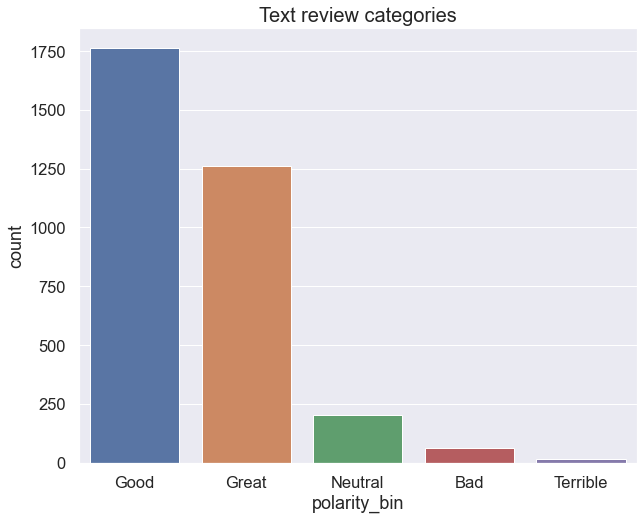

In [139]:
import seaborn as sns
plt.rcParams['figure.figsize'] = [10, 8]
sns.countplot(df_grouped.polarity_bin)
plt.title("Text review categories", fontsize = 20)

In [140]:
df_grouped[(df_grouped['polarity_bin'] == "Good") & (df_grouped['total reviews'] > 10)]

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


rating  review polarity  \
name                                                                      
40 Berkeley Hostel                            3.329193         0.344507   
A Bed & Breakfast In Cambridge                3.574074         0.368563   
AC Hotel Chicago Downtown                     4.081818         0.225766   
ARIA Resort Casino                            4.503597         0.310494   
Acorn Motor Inn                               3.750000         0.445194   
...                                                ...              ...   
Wingate By Wyndham Lagrange                   4.390244         0.316157   
Wingate By Wyndham Pueblo                     4.433333         0.244861   
Wyndham Garden-dallas North                   2.933333         0.388189   
Wyndham Vacation Resorts Towers On The Grove  4.050000         0.299545   
dana hotel and spa                            4.482609         0.270424   

                                              title polarity  \
name                                                           
40 Berkeley Hostel                                  0.397698   
A Bed & Breakfast In Cambridge                      0.362875   
AC Hotel Chicago Downtown                           0.217027   
ARIA Resort Casino                                  0.309409   
Acorn Motor Inn                                     0.354982   
...                                                      ...   
Wingate By Wyndham Lagrange                         0.157571   
Wingate By Wyndham Pueblo                           0.304505   
Wyndham Garden-dallas North                         0.396840   
Wyndham Vacation Resorts Towers On The Grove        0.200100   
dana hotel and spa                                  0.321974   

                                              review and title polarity  \
name                                                                      
40 Berkeley Hostel                                             0.386970   
A Bed & Breakfast In Cambridge                                 0.416348   
AC Hotel Chicago Downtown                                      0.303457   
ARIA Resort Casino                                             0.370237   
Acorn Motor Inn                                                0.462017   
...                                                                 ...   
Wingate By Wyndham Lagrange                                    0.329127   
Wingate By Wyndham Pueblo                                      0.300775   
Wyndham Garden-dallas North                                    0.432456   
Wyndham Vacation Resorts Towers On The Grove                   0.351609   
dana hotel and spa                                             0.342316   

                                              total reviews polarity_bin  \
name                                                                       
40 Berkeley Hostel                                      161         Good   
A Bed & Breakfast In Cambridge                           54         Good   
AC Hotel Chicago Downtown                                11         Good   
ARIA Resort Casino                                      139         Good   
Acorn Motor Inn                                          20         Good   
...                                                     ...          ...   
Wingate By Wyndham Lagrange                              41         Good   
Wingate By Wyndham Pueblo                               120         Good   
Wyndham Garden-dallas North                              15         Good   
Wyndham Vacation Resorts Towers On The Grove             20         Good   
dana hotel and spa                                       46         Good   

                                              popularity  
name                                                      
40 Berkeley Hostel                                 536.0  
A Bed & Breakfast In Cambridge                     193.0  
AC Hotel Chicago Downtown             

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Review Compound Polarity Score')

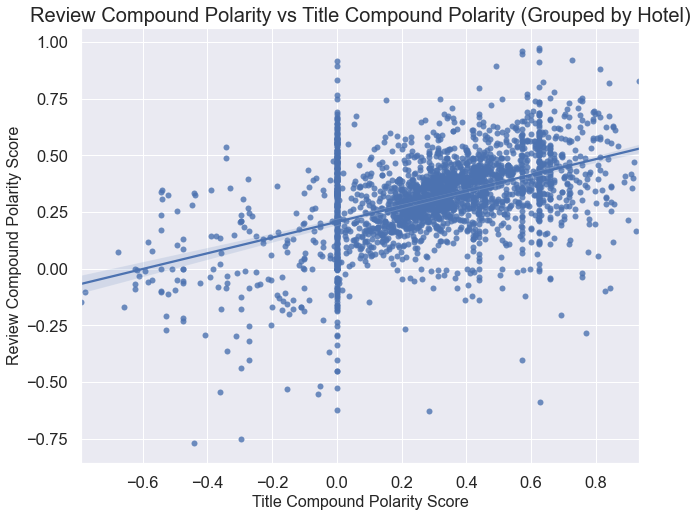

In [141]:
sns.regplot(y = "review polarity", x = "title polarity", data=df_grouped)
plt.title("Review Compound Polarity vs Title Compound Polarity (Grouped by Hotel)", fontsize = 20)
plt.xlabel('Title Compound Polarity Score', fontsize=16)
plt.ylabel('Review Compound Polarity Score', fontsize=16)
# plt.savefig('./Figures/text_title_polarity_grouped.jpg')

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Average Rating')

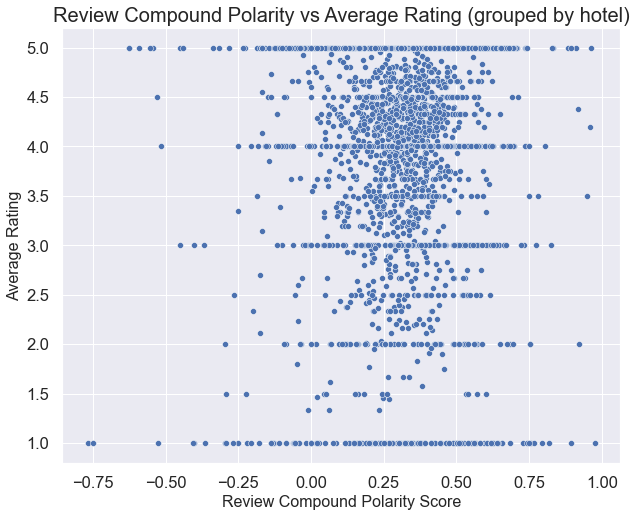

In [142]:
sns.scatterplot(y = "rating", x = "review polarity", data=df_grouped)
plt.title("Review Compound Polarity vs Average Rating (grouped by hotel)", fontsize = 20)
plt.xlabel('Review Compound Polarity Score', fontsize=16)
plt.ylabel('Average Rating', fontsize=16)
# plt.savefig('./Figures/review_rating_polarity_grouped.jpg')

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Average Rating')

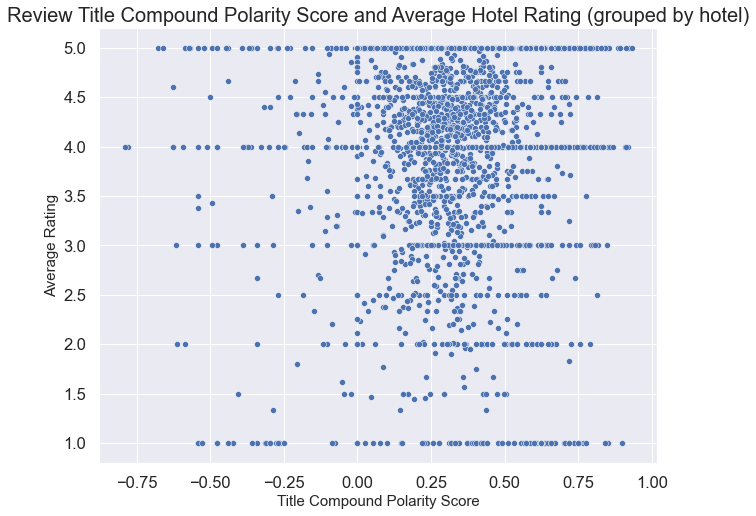

In [143]:
sns.scatterplot(y = "rating", x = "title polarity", data=df_grouped)
plt.title("Review Title Compound Polarity Score and Average Hotel Rating (grouped by hotel)", fontsize = 20)
plt.xlabel('Title Compound Polarity Score', fontsize=15)
plt.ylabel('Average Rating', fontsize=15)
# plt.savefig('./Figures/title_rating_polarity_grouped.jpg')

In [144]:
df_grouped.sort_values("popularity", ascending=False).iloc[0:10]

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


rating  review polarity  \
name                                                                         
The Alexandrian, Autograph Collection            4.483489         0.342638   
Howard Johnson Inn - Newburgh                    2.752475         0.289461   
Comfort Suites                                   3.996675         0.259797   
Americas Best Value Inn                          2.757315         0.265268   
Ip Casino Resort Spa                             4.068798         0.314885   
Best Western Plus Waterville Grand Hotel         3.675150         0.257131   
Anaheim Marriott Suites                          4.333091         0.272453   
Best Western Plus French Quarter Landmark Hotel  4.171930         0.259140   
Best Western of Long Beach                       3.662461         0.233136   
Doubletree By Hilton West Palm Beach Airport     4.166667         0.239023   

                                                 title polarity  \
name                                                              
The Alexandrian, Autograph Collection                  0.339285   
Howard Johnson Inn - Newburgh                          0.264384   
Comfort Suites                                         0.263943   
Americas Best Value Inn                                0.244490   
Ip Casino Resort Spa                                   0.287529   
Best Western Plus Waterville Grand Hotel               0.231763   
Anaheim Marriott Suites                                0.273640   
Best Western Plus French Quarter Landmark Hotel        0.284652   
Best Western of Long Beach                             0.224009   
Doubletree By Hilton West Palm Beach Airport           0.220573   

                                                 review and title polarity  \
name                                                                         
The Alexandrian, Autograph Collection                             0.420432   
Howard Johnson Inn - Newburgh                                     0.347713   
Comfort Suites                                                    0.306821   
Americas Best Value Inn                                           0.326534   
Ip Casino Resort Spa                                              0.362086   
Best Western Plus Waterville Grand Hotel                          0.328907   
Anaheim Marriott Suites                                           0.358832   
Best Western Plus French Quarter Landmark Hotel                   0.325795   
Best Western of Long Beach                                        0.290061   
Doubletree By Hilton West Palm Beach Airport                      0.292905   

                                                 total reviews polarity_bin  \
name                                                                          
The Alexandrian, Autograph Collection                     1181         Good   
Howard Johnson Inn - Newburgh                              707         Good   
Comfort Suites                                             421         Good   
Americas Best Value Inn                                    581         Good   
Ip Casino Resort Spa                                       391         Good   
Best Western Plus Waterville Grand Hotel                   334         Good   
Anaheim Marriott Suites                                    275         Good   
Best Western Plus French Quarter Landmark Hotel            285         Good   
Best Western of Long Beach                                 317         Good   
Doubletree By Hilton West Palm Beach Airport               276         Good   

                                                 popularity  
name                                                         
The Alexandrian, Autograph Collection                5295.0  
Howard Johnson Inn - Newburgh                        1946.0  
Comfort Suites                                       1682.6  
Americas Best Value Inn                              1602.0  
Ip Casino Resort Spa                               

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


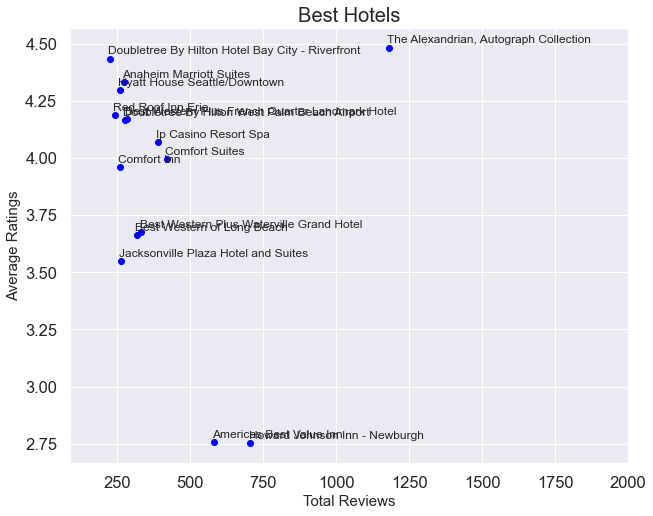

In [145]:
most_popular = df_grouped.sort_values("popularity", ascending=False).iloc[0:15]

for index, hotel in enumerate(most_popular.index):
    x = most_popular['total reviews'].loc[hotel]
    y = most_popular.rating.loc[hotel]
    plt.scatter(x, y, color='blue')
    plt.text(x-6, y+.02, hotel, fontsize=12)
    plt.xlim(90, 2000) 
    #plt.ylim(0,4.5) 
    
plt.title('Best Hotels', fontsize=20)
plt.xlabel('Total Reviews', fontsize=15)
plt.ylabel('Average Ratings', fontsize=15)
# plt.savefig('./Figures/popularity_plot.jpg')
plt.show()

## TF-IDF Vectorizer

TD-IDF and Prepare training and testing datasets </h2>

In [146]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = 0.3, random_state = 28)

C:\Users\kizun\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [148]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train['review'])
#X_train.A

In [149]:
y_train = train['rating']
#y_train

In [150]:
X_test = vectorizer.transform(test['review'])
y_test = test['rating']
#X_test.A

In [167]:
#pd.DataFrame.sparse.from_spmatrix(X_train)

0      1      2      3      4      5      6      7      8      9      \
0        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
35646    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
35647    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
35648    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
35649    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
35650    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

       ...  28519  28520  28521  28522  28523  28524  28525  28526  28527  \
0      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4      ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
35646  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
35647  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
35648  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
35649  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
35650  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

       28528  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  
...      ...  
35646    0.0  
35647    0.0  
35648    0.0  
35649    0.0  
35650    0.0  

[35651 rows x 28529 columns]

# Model Development

<li> Regression on raw target
<li> 5-class classification using transformed integer ratings
<li> 3-class classification using ratings grouped into three categories: 'Good', 'Neutral', and 'Bad'.
<li> Binary classification using ratings grouped into two categories, 'Good' and 'Bad', which will be denoted by a 1 and 0, respectively.

<h2> Regression Models </h2>

#### For regression, models will be trained on both reviews text and title text

Notice above in our EDA that many user ratings are not integers. Based on this, we will initially train a set of regression models and evaluate their performance and then train multi- and binary classifiers after transforming the ratings variable.

In [151]:
def fit_reg_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
    
    model_r2 = r2_score(y_test, y_pred)
    model_mse = mean_squared_error(y_test, y_pred)
    model_evs = explained_variance_score(y_test, y_pred)
    
    return model_r2, model_mse, model_evs

In [152]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR


lin_reg = linear_model.LinearRegression() 
dct_reg = DecisionTreeRegressor(max_depth = 5)
rf_reg = RandomForestRegressor(max_depth = 5, random_state = 0)
knn_reg = KNeighborsRegressor(n_neighbors = 2)
mlp_reg = MLPRegressor(random_state = 1, max_iter = 500)
svm_reg = LinearSVR()

all_reg_models = [lin_reg, dct_reg, rf_reg, knn_reg, mlp_reg, svm_reg]
reg_models_perf = []

for model in all_reg_models:
    model_r2, model_mse, model_evs = fit_reg_model(model)
    reg_models_perf.append({'R-squared' : model_r2, 'Mean squared error' : model_mse, 'Explained variance score': model_evs})
    
reg_models_df = pd.DataFrame(reg_models_perf)
# reg_models_df                    

In [153]:
reg_models_df['Model'] = ['Linear Regression', 'Decision Tree Regressor', 'Random Forest Regressor', 
                          'Nearest Neighbors Regressor', 'Multi-layer Perceptron', 'Support Vector Machine']
reg_models_df.rename(columns={'R-quared': 'R-squared'}, inplace = True)
reg_models_df.set_index('Model', inplace = True)
reg_models_df

R-squared  Mean squared error  \
Model                                                        
Linear Regression            -0.460850            2.389347   
Decision Tree Regressor       0.272250            1.190298   
Random Forest Regressor       0.294574            1.153785   
Nearest Neighbors Regressor   0.259612            1.210968   
Multi-layer Perceptron        0.394410            0.990494   
Support Vector Machine        0.568882            0.705130   

                             Explained variance score  
Model                                                  
Linear Regression                           -0.460850  
Decision Tree Regressor                      0.272658  
Random Forest Regressor                      0.295050  
Nearest Neighbors Regressor                  0.262779  
Multi-layer Perceptron                       0.394460  
Support Vector Machine                       0.572561

In [154]:
reg_models_df.sort_values(by = 'R-squared')

R-squared  Mean squared error  \
Model                                                        
Linear Regression            -0.460850            2.389347   
Nearest Neighbors Regressor   0.259612            1.210968   
Decision Tree Regressor       0.272250            1.190298   
Random Forest Regressor       0.294574            1.153785   
Multi-layer Perceptron        0.394410            0.990494   
Support Vector Machine        0.568882            0.705130   

                             Explained variance score  
Model                                                  
Linear Regression                           -0.460850  
Nearest Neighbors Regressor                  0.262779  
Decision Tree Regressor                      0.272658  
Random Forest Regressor                      0.295050  
Multi-layer Perceptron                       0.394460  
Support Vector Machine                       0.572561

In [155]:
reg_models_df.sort_values(by = 'Mean squared error', ascending = False)

R-squared  Mean squared error  \
Model                                                        
Linear Regression            -0.460850            2.389347   
Nearest Neighbors Regressor   0.259612            1.210968   
Decision Tree Regressor       0.272250            1.190298   
Random Forest Regressor       0.294574            1.153785   
Multi-layer Perceptron        0.394410            0.990494   
Support Vector Machine        0.568882            0.705130   

                             Explained variance score  
Model                                                  
Linear Regression                           -0.460850  
Nearest Neighbors Regressor                  0.262779  
Decision Tree Regressor                      0.272658  
Random Forest Regressor                      0.295050  
Multi-layer Perceptron                       0.394460  
Support Vector Machine                       0.572561

In [156]:
reg_models_df.sort_values(by = 'Explained variance score')

R-squared  Mean squared error  \
Model                                                        
Linear Regression            -0.460850            2.389347   
Nearest Neighbors Regressor   0.259612            1.210968   
Decision Tree Regressor       0.272250            1.190298   
Random Forest Regressor       0.294574            1.153785   
Multi-layer Perceptron        0.394410            0.990494   
Support Vector Machine        0.568882            0.705130   

                             Explained variance score  
Model                                                  
Linear Regression                           -0.460850  
Nearest Neighbors Regressor                  0.262779  
Decision Tree Regressor                      0.272658  
Random Forest Regressor                      0.295050  
Multi-layer Perceptron                       0.394460  
Support Vector Machine                       0.572561

<h1> Classification </h1>

#### In this section of the notebook, we will train a set of 5-class classifiers, a set of 3-class classifiers, and finally, a set of binary classifiers.

Uncomment and run the pip command bleow if you do not currently have the imbndlearn package installed

In [157]:
# !pip install imblearn

In [158]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn import model_selection

import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import pylab as pl
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

##### Using a TF-IDF Vectorizer, we prepare the train and test datasets in a 80:20 train-test split.

In [159]:
def get_train_test_data(text_df, target_df):
    vectorizer = TfidfVectorizer(stop_words='english')
    X_train,X_test,y_train,y_test = train_test_split(vectorizer.fit_transform(text_df).toarray(),
                                                 target_df.values,test_size = 0.2,
                                                 random_state=123)
    feature_names = vectorizer.get_feature_names()
    
    return X_train,X_test,y_train,y_test

##### Treating imbalanced data using Synthetic Minority Over-sampling Technique (SMOTE):

In [160]:
def get_SMOTE_data(X_train, y_train):
    from imblearn.over_sampling import SMOTE

    # oversampling the train dataset using SMOTE
    smt = SMOTE()
    X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

    return X_train_sm, y_train_sm

##### Next, we define a function that trains each classifier for each classification method, and a function that computes the precision-recall pairs: 

In [161]:
# Function that fits a decision tree, random forest, bagging classifier, and a logistic regression model on the training data passed
# as an argument, and subsequently computes the predicted labels on the test set.
def get_clf_predictions(X_train,y_train,X_test):
    dt_model = DecisionTreeClassifier(random_state=123).fit(X_train,y_train)
    rf_model = RandomForestClassifier(random_state=123).fit(X_train,y_train)
    bag_model = BaggingClassifier(random_state=123).fit(X_train,y_train)
    lr_model = LogisticRegression(random_state=123).fit(X_train,y_train)
    
    y_score = pd.DataFrame({
        'Decision Tree': dt_model.predict_proba(X_test)[:,1],
        'Random Forest': rf_model.predict_proba(X_test)[:,1],
        'Bagging Classifier': bag_model.predict_proba(X_test)[:,1],
        'Logistic Regression': lr_model.predict_proba(X_test)[:,1]
    })
    
    y_pred = pd.DataFrame({
        'Decision Tree': dt_model.predict(X_test),
        'Random Forest': rf_model.predict(X_test),
        'Bagging Classifier': bag_model.predict(X_test),
        'Logistic Regression': lr_model.predict(X_test)
    })
    
    return y_score, y_pred, dt_model, rf_model, bag_model, lr_model

In [162]:
def get_accuracy(y_test, y_pred, method=''):
    print(method + ' Classification Performance')
    print('-------------------------------------')
    print("Decision Tree Accuracy:\t\t%1.2f "%accuracy_score(y_test,y_pred5['Decision Tree']))
    print("Random Forest Accuracy:\t\t%1.2f "%accuracy_score(y_test,y_pred5['Random Forest']))
    print("Bagging Classifier Accuracy:\t%1.2f "%accuracy_score(y_test,y_pred5['Bagging Classifier']))
    print("Logistic Regression Accuracy:\t%1.2f "%accuracy_score(y_test,y_pred5['Logistic Regression']))

<h4> 5-class classification </h4>

Multiclass classification using a target with five categories:
$$r_i \in \{1,2,3,4,5\}$$

where $r_i$ denotes the $i^{th}$ hotel rating.

In [163]:
# We first must transform the ratings to integer values:
integer_ratings = []
for rating in df['rating']:
    integer_ratings.append(np.rint(rating))  # rounds ratings to nearest integer
    
df['five_class_target'] = integer_ratings

In [164]:
# Training model on review text only
X_train5, X_test5, y_train5, y_test5 = get_train_test_data(df['text'], df['five_class_target'])

In [165]:
X_train5_sm, y_train5_sm = get_SMOTE_data(X_train5, y_train5)

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
from collections import Counter
counter_before = Counter(y_train5)
counter_after = Counter(y_train5_sm)
print('Before SMOTE: ', counter_before)
print('After SMOTE: ', counter_after)

##### Training models on over-sampled data

In [ ]:
y_score5, y_pred5, dt_model5, rf_model5, bag_model5, lr_model5 = get_clf_predictions(X_train5_sm, y_train5_sm, X_test5)

In [ ]:
get_accuracy(y_test5, y_pred5, method='5-Class')

In [ ]:
# Training model on the review title text now
X_train5,X_test5,y_train5,y_test5 = get_train_test_data(df['title'], df['five_class_target'])

In [ ]:
y_score5, y_pred5, dt_model5, rf_model5, bag_model5, lr_model5 = get_clf_predictions(X_train5,y_train5,X_test5)

In [ ]:
get_accuracy(y_test5, y_pred5, method='5-Class')

<h4> 3-class classification </h4>

Multiclass classification using a target with three categories. Hotel ratings with be partitioned into three group, or categories - Bad, Neutral, Good - which will be encoded by 0, 1, and 2, respectively.

In [ ]:
def multiclass_bins(r):
    if r >= 4 and r <= 5:
        return "Good"
    elif r > 2 and r < 4:
        return "Neutral"
    else:
        return "Bad"

get_mult_bins = lambda r: multiclass_bins(r)

df['three_class_target'] = df.rating.apply(get_mult_bins)
df

In [ ]:
X_train3,X_test3,y_train3,y_test3 = get_train_test_data(df['text'], df['three_class_target'])

In [ ]:
X_train3_sm, y_train3_sm = get_SMOTE_data(X_train3, y_train3)

##### Training models on over-sampled data

In [ ]:
y_score3, y_pred3, dt_model3, rf_model3, bag_model3, lr_model3 = get_clf_predictions(X_train3_sm, y_train3_sm, X_test3)

In [ ]:
get_accuracy(y_test3, y_pred3, method='3-Class')

<h4> Binary Classification</h4>

In [ ]:
binary_target = []
for rating in df['rating']:
    if rating <=3:
        binary_target.append(0)
    else:
        binary_target.append(1)
df['binary_target'] = binary_target

In [ ]:
df['binary_target']

In [ ]:
# Training on review text only
X_train2,X_test2,y_train2,y_test2 = get_train_test_data(df['text'], df['binary_target'])

In [ ]:
X_train2_sm, y_train2_sm = get_SMOTE_data(X_train2, y_train2)

In [ ]:
y_score2, y_pred2, dt_model2, rf_model2, bag_model2, lr_model2 = get_clf_predictions(X_train2_sm, y_train2_sm, X_test2)

<h4> Model performance functions for binary classifiers </h4>

In [ ]:
# Plots the ROC curves for each classifer and the area under the ROC curve (AUC).
def get_roc(y_test, y_score, method=''):
    scores =[y_score['Decision Tree'],y_score['Random Forest'], y_score['Bagging Classifier'], y_score['Logistic Regression']]
    model = ['Decision Tree', 'Random Forest', 'Bagging Classifier', 'Logistic Regression']

    fpr = dict()
    tpr = dict()

    %matplotlib inline
    plt.figure(figsize=(8,7))

    for i in range(len(scores)):
        fpr[i], tpr[i], thresholds = roc_curve(y_test, scores[i])
        plt.plot(fpr[i],tpr[i], label=model[i]+'(AUC = %0.2f)'%roc_auc_score(y_test,scores[i]))

    # fig1, ax1 = plt.subplots(figsize=(8,6))
    # ax1.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test,y_score), color='blue')
    plt.plot([0, 1],[0, 1], linestyle='--', color='red', label='Random')
    # plt.fill_between(fpr, 0, tpr, color='lightgray', alpha=0.3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC Curves - Binary Classification ('+ method +' Text Only)')
    plt.legend(loc="lower right", prop={'family':'sans-serif','size':14.5}, shadow=True)
#     plt.savefig('./Figures/roc_'+method+'.jpg')
    return None


# Computes the various precision and recall values for thresholds ranging from 0 to 1 (with a 0.05 step size).
def get_pr_thresholds(y_test,y_score):
    import numpy as np
    thresholds = np.arange(0, 1, 0.05)
    threshold_list = list(thresholds)
    columns = list(y_score.columns)
    precisions = []
    recalls = []
    model_labels = []
    thres_lst = []
    for column in columns:
        for threshold in threshold_list:
            y_pred = (y_score > threshold).astype(int)
            
            precision = precision_score(y_test,y_pred[column])
            recall = recall_score(y_test,y_pred[column])
            label=str(column)
            thres=str(threshold)
            precisions.append(precision)
            recalls.append(recall)
            model_labels.append(label)
            thres_lst.append(thres)
    pr_df = pd.DataFrame({'model_label':model_labels,
                         'threshold': thres_lst,
                         'precision':precisions,
                         'recall':recalls})
    return pr_df

# Computes and prints performance metrics for each binary classifier
def get_binary_performance(y_test, y_pred, method=''):
    from sklearn.metrics import f1_score
    predictions =[y_pred['Decision Tree'],y_pred['Random Forest'], y_pred['Bagging Classifier'], y_pred['Logistic Regression']]
    models = ['Decision Tree', 'Random Forest', 'Bagging Classifier', 'Logistic Regression']
    
    
    for i in range(len(predictions)):
        print(models[i]+' Performance ('+ method +' Text Only)')
        print('---------------------------------------------------')
        print("Precision:\t\t\t%1.2f "%(precision_score(y_test[i], predictions[i])))
        print("Recall/TPR:\t\t\t%1.2f "%(recall_score(y_test[i],predictions[i])))
        print("F1 Score:\t\t\t%1.2f "%(f1_score(y_test[i],predictions[i])))
        print("Accuracy:\t\t\t%1.2f "%(accuracy_score(y_test[i],predictions[i])))
        print('\n')

In [ ]:
get_roc(y_test2, y_score2, 'Review')

In [ ]:
get_binary_performance(y_test2, y_pred2, 'Review')

In [ ]:
pr_thresholds = get_pr_thresholds(y_test2, y_score2)
pr_thresholds.sort_values(by=['recall'],ascending=False,inplace=True)
pr_thresholds.head(20)

In [ ]:
plt.clf()
groups = pr_thresholds.groupby('model_label')

#Plot
fig, ax = plt.subplots(figsize = 15,15)
ax.set_xlim([0,1])
ax.set_ylim([0,1])

for name, group in groups:
    ax.plot(group.recall, group.precision, marker='o', linestyle='', ms=12, label=name)

plt.legend(bbox_to_anchor=(0, .5), loc='right', ncol=1)
# plt.savefig('./Figures/pr_binary.jpg')
plt.show()

In [ ]:
plt.clf()
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

#precision, recall, thresholds = precision_recall_curve(y_train, training_predictions)
#average_precision = average_precision_score(y_train, training_predictions)


precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

step_kwargs = ({'step' : 'post'})

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.savefig('./Figures/pr_curve_binary.jpg')
plt.show()

#### Binary classifiers on title text data only:

In [ ]:
# Training on title text only
X_train2,X_test2,y_train2,y_test2 = get_train_test_data(df['title'], df['binary_target'])

In [ ]:
y_score2, y_pred2, dt_model2, rf_model2, bag_model2, lr_model2 = get_clf_predictions(X_train2,y_train2,X_test2)

In [ ]:
get_roc(y_test2, y_score2, 'Title')

In [ ]:
get_binary_performance(y_test2, y_pred2, 'Title')

### Hyperparamter Tuning/Optimization using Random Search

Hyperparameter tuning will only be performed for one classification method as it requires a very long run-time. In particular, we compute the "best" parameters on a logistic regression model for binary classification. 

In [ ]:
parameters = {
     'n_estimators':(10, 30, 50), # the number of trees
     'max_depth':(4,5,6,8,10,15), # the maximum depth of each decision tree (you don't want it to be too deep since then nodes would have fewer observations)
     'min_samples_split': (2, 4, 8), # at each intermediate node (non-leaf node), the minimum number of examples/observations in that node. If the number of datapoints is fewer than this h-param, then it won't do the split.
     'min_samples_leaf': (4,8,12,16) # the minimum sample size (# of obs) at each leaf node
}

model = GridSearchCV(LogisticRegression(), parameters, cv=3, random_state=123)
model.fit(X_train2_sm, y_train2_sm)
model.best_score_, model.best_params_   # prints the best score achieved and the best hyperparameters

In [ ]:
best_params = model.best_params_

In [ ]:
model = LogisticRegression(best_params, random_state=123)
model.fit(X_train,y_train)

<h2>Map</h2>

In [ ]:
import json
import geojsonio
import folium


def createGeoJsonObject(df):
    points_dict = dict()
    points_dict['type'] = 'FeatureCollection'
    points_dict_features = list()
    points_dict['features'] = points_dict_features
    
    # Iterate through all the (lat,long) pairs
    for idx, row in df.iterrows():
        
        item = dict()
        item['type'] = 'Feature'
        
        # Assign point ids
        item['properties'] = {'point_id' : idx}
        
        # Assign point coordinates
        geometry = dict()
        geometry['type'] = 'Point'
        
        lat = row['latitude']
        long = row['longitude']
        
        geometry['coordinates'] = [long, lat]
        
        item['geometry'] = geometry
        
        points_dict_features.append(item)
        
    return points_dict

In [ ]:
hotels_json = createGeoJsonObject(df)

In [ ]:
m = folium.Map(location = [12.376187, 45.421611],zoom_start = 10)
m.choropleth(geo_data = hotels_json, data = sizes,
             columns =['Pick-up Zone', 'Number of Pickups'],
             key_on = 'feature.properties.point_id',
             fill_color = 'RdYlGn', fill_opacity = 0.7, line_opacity = 0.8,
             legend_name = 'Distribution of Incidents')
folium.LayerControl().add_to(m)

m